# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**
### Tecnológico de Monterrey
### Prof.: Dra. Grettel Barceló

## **Actividad Semana 6**

### **Modelos Alternativos**

##### Nombres y matrículas de los integrantes del equipo:
*   Omar Juárez Téllez - A01795499
*   Victoria Melgarejo Cabrera - A01795030
*   Julio Cesar Mestas - A01794827


# Avance4 — Comparador de **6** modelos de anomalías
Modelos incluidos:
1) **Isolation Forest (IF)**
2) **One-Class SVM (RBF)**
3) **Local Outlier Factor (LOF, novelty=True)**
4) **Autoencoder (MSE recon)**
5) **PCA (std) / Robust PCA*** — reconstrucción MSE | — MCD sobre residuales
6) **Deep SVDD** (one-class deep)






## **1. Importación de Librerías**

In [ ]:
# =========================
# 0) Imports & configuración
# =========================
import os, gc, json, glob, warnings
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import MinCovDet
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)

# Carpeta de salida
OUTPUT_DIR = "./eda_outputs"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
print("OUTPUT_DIR =", OUTPUT_DIR)


OUTPUT_DIR = ./eda_outputs


## 2) Carga de datos (ajusta rutas)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2.1 Preparación del Entorno y Lectura del Dataset**

In [ ]:
# === Ajusta estas rutas a tu Drive ===
base_path = "/content/drive/Othercomputers/Mi PC/Google Drive/Documentos/Tec de Monterrey/MNA/PROYECTO INTEGRADOR/SEMANA 6/Resultados/"

file_name_train = "1_PROCESAMIENTO_ALEATORIO_TRAIN_60.xlsx"
file_name_val   = "1_PROCESAMIENTO_ALEATORIO_VAL_20.xlsx"
file_name_test  = "1_PROCESAMIENTO_ALEATORIO_TEST_20.xlsx"

df_mastertable_train = pd.read_excel(f"{base_path}/{file_name_train}")
df_mastertable_val   = pd.read_excel(f"{base_path}/{file_name_val}")
df_mastertable_test  = pd.read_excel(f"{base_path}/{file_name_test}")

for df in (df_mastertable_train, df_mastertable_val, df_mastertable_test):
    if "FECHA_MES_5" in df.columns:
        df["FECHA_MES_5"] = pd.to_datetime(df["FECHA_MES_5"].astype(str).str.strip(), errors="coerce")

print("Shapes:", df_mastertable_train.shape, df_mastertable_val.shape, df_mastertable_test.shape)


In [ ]:
# Validamos la correcta carga de los dataset
rows1, cols1 = df_mastertable_train.shape
rows2, cols2 = df_mastertable_val.shape
rows3, cols3 = df_mastertable_test.shape

print(f"Dimensiones Train: {rows1:,} filas × {cols1:,} columnas")
print(f"Dimensiones Val: {rows2:,} filas × {cols2:,} columnas")
print(f"Dimensiones Test: {rows3:,} filas × {cols3:,} columnas")

print("\nTipos de datos train (por columna):")
print(df_mastertable_train.dtypes)
print("\nResumen de tipos train (conteo por dtype):")
print(df_mastertable_train.dtypes.value_counts())
print("\nPrimeras 3 filas train:")
display(df_mastertable_train.head(3))

Dimensiones Train: 1,713 filas × 77 columnas
Dimensiones Val: 570 filas × 77 columnas
Dimensiones Test: 572 filas × 77 columnas

Tipos de datos train (por columna):
Unnamed: 0                               int64
ID_EHT                                  object
FECHA_MES_5                     datetime64[ns]
CODMES                                   int64
target_hosp_15d                          int64
                                     ...      
kw_dm_w30d                             float64
rx_antidiabeticos_w30d_yj              float64
rx_antihipertensivos_w30d_yj           float64
kw_dm_w30d_sqrt                        float64
kw_dolor_w30d_sqrt                     float64
Length: 77, dtype: object

Resumen de tipos train (conteo por dtype):
float64           60
int64             15
object             1
datetime64[ns]     1
Name: count, dtype: int64

Primeras 3 filas train:


,Unnamed: 0,ID_EHT,FECHA_MES_5,CODMES,target_hosp_15d,target_hosp_21d,target_hosp_30d,target_hosp_90d,GENERO_bin,REGION_REGION_Bajío,REGION_REGION_Centro,REGION_REGION_Norte,REGION_REGION_Occidente,REGION_REGION_Otros,REGION_REGION_Sur,rx_polifarmacia_30d,target_hospitalizaciones,ACIDO_URICO,ALBUMINA,ALBUMINA_EN_SUERO,BILIRRUBINA_DIRECTA,BILIRRUBINA_INDIRECTA,BILIRRUBINA_TOTAL,CALCIO,COLESTEROL_HDL,COLESTEROL_LDL,COLESTEROL_TOTAL,COLESTEROL_VLDL,CREATININA_SERICA,DENSIDAD,DESHIDROGENASA_LACTICA,ERITROCITOS,FOSFATA_ALCALINA,FOSFORO,GLOBULINA,GLUCOSA_EN_SUERO_AYUNO,HEMATOCRITOS,HEMOGLOBINA,HEMOGLOBINA_GLUCOSILADA_HBA1C,HIERRO,IMC,INDICE_ATEROGENICO,LEUCOCITOS_TOTALES,NITROGENO_UREICO_BUN,OXIMETRIA_CAPILAR,PESO,PH,PLAQUETAS,POTASIO,PROTEINA_C_REACTIVA,PROTEINA_TOTAL,SODIO,TALLA,TENSION_ARTERIAL_SISTOLICA,TRIGLICERIDOS,TENSION_ARTERIAL_DIASTOLICA,DIAS_EN_PROGRAMA,EDAD,rx_w30d,rx_meds_unicos_30d,rx_consultas_30d,rx_estatinas_w30d,rx_antibioticos_w30d,rx_antihipertensivos_w30d,rx_antidiabeticos_w30d,notas_w30d,tokens_notas_w30d,kw_adherencia_w30d,kw_infeccion_w30d,kw_fiebre_w30d,kw_htn_w30d,kw_dolor_w30d,kw_dm_w30d,rx_antidiabeticos_w30d_yj,rx_antihipertensivos_w30d_yj,kw_dm_w30d_sqrt,kw_dolor_w30d_sqrt
0,0,Csalinas2265705,2024-06-05,202406,0,0,0,0,1,0,0,1,0,0,0,0,0,-0.057637,-0.003861,-0.055975,-0.151342,-0.138895,-0.136610,0.068664,-0.061834,-0.061837,-0.021808,-0.047827,-0.119189,-0.034385,-0.039497,0.011872,-0.003922,-0.004845,-0.063189,-0.147185,-0.038616,-0.016732,-0.076303,-0.071259,-0.065934,-0.117818,-0.067377,-0.149834,0.041516,-0.036560,-0.072222,-0.074081,-0.064306,-0.108807,-0.042608,0.079237,-0.009969,-0.084660,-0.146213,0.066768,-1.771520,-0.531436,-0.292351,-0.233136,-0.432841,-0.374291,-0.028072,-0.370644,-0.342145,-0.306936,-0.094991,-0.08409,-0.256992,-0.098286,-0.458694,-0.311072,-0.498951,-0.550186,-0.581084,-0.630082,-0.403078
1,2,aalvado2172827,2024-06-05,202406,0,0,0,0,1,0,0,1,0,0,0,1,0,0.872943,-3.157275,-0.047614,0.279302,0.085861,0.194403,1.008562,-0.557430,-0.886682,-0.888097,2.905193,1.927319,-0.034672,-0.898523,3.062061,-1.713101,0.809354,0.861567,-1.046601,1.868528,1.949913,0.493756,3.584083,-0.065934,2.577100,-0.066021,1.094557,0.041516,-0.036560,-0.534936,-0.074081,0.002131,-0.108807,-0.042608,0.368013,-0.009969,-0.084660,0.785793,0.066768,-0.019571,-0.860201,0.204066,1.415420,-0.432841,0.310055,-0.028072,0.871046,0.618359,-0.320583,-0.527919,-0.08409,-0.256992,-0.098286,0.037163,-0.311072,0.191386,2.075152,2.055599,0.760192,-0.403078
2,3,aanaya2145400,2024-06-05,202406,0,0,0,0,1,0,0,0,1,0,0,1,0,0.735805,-0.003861,-0.055975,-0.151342,-0.138895,-0.136610,-0.526605,-0.061834,-0.061837,0.618492,-0.047827,1.025406,-0.034385,-0.039497,0.011872,-0.003922,0.972194,-0.063189,-0.801814,-1.274231,-1.498102,-0.076303,-0.071259,0.255311,-0.117818,-0.069148,0.611403,0.041516,1.121614,-0.072222,-0.077161,-0.089482,-0.108807,-0.042608,0.295819,1.259107,2.316527,-0.887039,0.121970,0.591913,0.652117,-0.187675,4.712532,1.029599,-0.500895,-0.028072,-0.370644,-0.342145,-0.006974,0.647374,-0.08409,2.279055,-0.098286,0.897457,-0.311072,1.102065,-0.550186,-0.581084,1.487147,-0.403078


**2.2 Inferencia de Tipos y Fechas (limpieza ligera)**

In [ ]:
# --- Poblacion ---
df_mastertable_train["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_train["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

df_mastertable_val["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_val["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

df_mastertable_test["FECHA_MES_5"] = pd.to_datetime(
    df_mastertable_test["FECHA_MES_5"].astype(str).str.strip(),
    format="%Y-%m-%d", errors="coerce"
)

## 3) Features, matrices y utilidades comunes

In [ ]:
id_cols = ["ID_EHT","FECHA_MES_5","CODMES"]

vars_in = [
    "GENERO_bin","REGION_REGION_Bajío","REGION_REGION_Centro","REGION_REGION_Norte",
    "REGION_REGION_Occidente","REGION_REGION_Otros","REGION_REGION_Sur",
    "ACIDO_URICO","ALBUMINA","ALBUMINA_EN_SUERO","BILIRRUBINA_DIRECTA","BILIRRUBINA_INDIRECTA",
    "BILIRRUBINA_TOTAL","CALCIO","COLESTEROL_HDL","COLESTEROL_LDL","COLESTEROL_TOTAL","COLESTEROL_VLDL",
    "CREATININA_SERICA","DENSIDAD","DESHIDROGENASA_LACTICA","ERITROCITOS","FOSFATA_ALCALINA","FOSFORO",
    "GLOBULINA","GLUCOSA_EN_SUERO_AYUNO","HEMATOCRITOS","HEMOGLOBINA","HEMOGLOBINA_GLUCOSILADA_HBA1C",
    "HIERRO","IMC","INDICE_ATEROGENICO","LEUCOCITOS_TOTALES","NITROGENO_UREICO_BUN","OXIMETRIA_CAPILAR",
    "PESO","PH","PLAQUETAS","POTASIO","PROTEINA_C_REACTIVA","PROTEINA_TOTAL","SODIO","TALLA",
    "TENSION_ARTERIAL_SISTOLICA","TRIGLICERIDOS","TENSION_ARTERIAL_DIASTOLICA",
    "DIAS_EN_PROGRAMA","EDAD"
]

def get_X(df, features):
    present = [c for c in features if c in df.columns]
    X = df[present].astype(float).values
    return X, present

def topk_threshold(scores, k=0.05):
    k = min(max(k, 1e-6), 0.99)
    thr = float(np.quantile(scores, 1.0 - k))
    flags = (scores >= thr).astype(int)
    return thr, flags

def summarize_alert_rate(df_with_flags, flag_col="flag"):
    return (df_with_flags.groupby("CODMES")[flag_col]
            .mean().rename("alerts_rate").reset_index())

# Matrices crudas y estandarizadas
X_tr_raw, feat_used = get_X(df_mastertable_train, vars_in)
X_va_raw, _         = get_X(df_mastertable_val,   feat_used)
X_te_raw, _         = get_X(df_mastertable_test,  feat_used)

scaler_std = StandardScaler().fit(X_tr_raw)
X_tr = scaler_std.transform(X_tr_raw)
X_va = scaler_std.transform(X_va_raw)
X_te = scaler_std.transform(X_te_raw)

print(f"X shapes: train {X_tr.shape}, val {X_va.shape}, test {X_te.shape}")


X shapes: train (1713, 48), val (570, 48), test (572, 48)


El conjunto de datos quedó particionado en TRAIN (n=1,713), VALID (n=570) y TEST (n=572), con 64 variables por observación (paciente–mes). Esta proporción (≈60/20/20) es adecuada para el enfoque no supervisado: permite aprender la estructura de “normalidad” en TRAIN, fijar el umbral operativo (top-k) en VALID y verificar estabilidad en TEST.

## 3.1) Métricas comunes

In [ ]:
def psi_score(base: np.ndarray, comp: np.ndarray, bins: int = 10) -> float:
    base = np.asarray(base, float); comp = np.asarray(comp, float)
    base = base[np.isfinite(base)]; comp = comp[np.isfinite(comp)]
    if len(base)==0 or len(comp)==0: return np.nan
    qs = np.linspace(0, 100, bins+1)
    cuts = np.unique(np.nanpercentile(base, qs))
    if len(cuts) <= 2:
        cuts = np.linspace(float(np.nanmin(base)), float(np.nanmax(base)+1e-9), bins+1)
    b, _ = np.histogram(base, bins=cuts); c, _ = np.histogram(comp, bins=cuts)
    bp = b / max(b.sum(),1); cp = c / max(c.sum(),1)
    eps=1e-6; bp = np.clip(bp, eps, 1); cp = np.clip(cp, eps, 1)
    return float(np.sum((bp - cp) * np.log(bp / cp)))

def percentiles(x: np.ndarray, qs=(1,5,25,50,75,95,99)) -> dict:
    x = np.asarray(x, float)
    return {f"p{int(q)}": float(np.nanpercentile(x, q)) for q in qs}

def cv_of(series: pd.Series) -> float:
    s = pd.Series(series, dtype=float); m = s.mean(); sd = s.std(ddof=0)
    return float(sd/m) if m not in (0, np.nan) else np.nan

def p50_p95_cv(df_split: pd.DataFrame, score_col="score") -> tuple[float,float]:
    g = (df_split.groupby("CODMES")[score_col]
         .agg(p50=lambda s: np.nanpercentile(s, 50),
              p95=lambda s: np.nanpercentile(s, 95))).reset_index()
    return cv_of(g["p50"]), cv_of(g["p95"])

def compute_persistence(df_sc: pd.DataFrame, id_col="ID_EHT", month_col="CODMES", flag_col="flag") -> float:
    d = df_sc[[id_col, month_col, flag_col]].dropna().sort_values([id_col, month_col])
    def has_consec(x):
        f = x[flag_col].to_numpy().astype(int)
        return bool(np.any((f[1:]==1) & (f[:-1]==1))) if f.size>1 else False
    pp = d.groupby(id_col).apply(has_consec)
    return float(pp.mean()) if len(pp) else np.nan

def export_model_scores_and_metrics(
    model_name: str,
    scores: dict,
    k_top: float = 0.05,
    psi_bins: int = 10,
    verbose: bool = True,         # imprime informe en Colab
    save_txt: bool = True,        # guarda informe en ./eda_outputs/report_{model}.txt
    # ==== NUEVOS PARÁMETROS DE GRÁFICAS ====
    plot_hist: bool = True,       # 1) Histograma de scores + umbral
    bins_hist: int = 40,
    plot_alert_rates: bool = True,# 2) Alert-rate mensual (VALID/TEST) + k
    plot_pca2d: bool = True,      # 3) PCA 2D (TEST) con anomalías resaltadas
    pca_random_state: int = 42,
    save_fig: bool = True         # guardar las figuras a disco
):
    # 1) Umbral desde VALID (top-k)
    thr, _ = topk_threshold(scores["VALID"], k=k_top)

    # 2) Construir dataframes por split (ids + score + flag + metadata)
    def build(df_base, split, vec):
        d = df_base[id_cols].copy()
        d["score"] = vec
        d["flag"] = (vec >= thr).astype(int)
        d["threshold_from_VALID"] = thr
        d["split"] = split
        d["model"] = model_name
        d["k_top"] = k_top
        return d

    dtr = build(df_mastertable_train, "TRAIN", scores["TRAIN"])
    dva = build(df_mastertable_val,   "VALID", scores["VALID"])
    dte = build(df_mastertable_test,  "TEST",  scores["TEST"])

    # 3) Persistir scores por split y combinado
    for ddf in (dtr, dva, dte):
        ddf.to_csv(os.path.join(OUTPUT_DIR, f"scores_{model_name}_{ddf['split'].iloc[0]}.csv"), index=False)
    pd.concat([dtr, dva, dte]).to_csv(os.path.join(OUTPUT_DIR, f"all_scores_{model_name}.csv"), index=False)

    # 4) Métricas de alert-rate por mes
    rates_tr = summarize_alert_rate(dtr, "flag")
    rates_va = summarize_alert_rate(dva, "flag")
    rates_te = summarize_alert_rate(dte, "flag")

    # 5) Resumen de estabilidad (media, DE, CV)
    def _rate_stats(r):
        mu = float(r["alerts_rate"].mean()) if len(r) else np.nan
        sd = float(r["alerts_rate"].std(ddof=0)) if len(r) else np.nan
        cv = float(sd / mu) if (pd.notna(mu) and mu != 0) else np.nan
        return mu, sd, cv

    tr_mu, tr_sd, tr_cv = _rate_stats(rates_tr)
    va_mu, va_sd, va_cv = _rate_stats(rates_va)
    te_mu, te_sd, te_cv = _rate_stats(rates_te)

    rate_stats = {
        "TRAIN_alert_rate_mean": tr_mu, "TRAIN_alert_rate_std": tr_sd, "TRAIN_alert_rate_cv": tr_cv,
        "VALID_alert_rate_mean": va_mu, "VALID_alert_rate_std": va_sd, "VALID_alert_rate_cv": va_cv,
        "TEST_alert_rate_mean":  te_mu, "TEST_alert_rate_std":  te_sd, "TEST_alert_rate_cv":  te_cv,
    }

    # 6) PSI y percentiles
    psi_va = psi_score(dtr["score"].values, dva["score"].values, bins=psi_bins)
    psi_te = psi_score(dtr["score"].values, dte["score"].values, bins=psi_bins)

    pct_tr = percentiles(dtr["score"].values)
    pct_va = percentiles(dva["score"].values)
    pct_te = percentiles(dte["score"].values)

    # 7) Estabilidad de ranking (p50/p95) y persistencia (≥2 meses seguidos)
    cv_p50_tr, cv_p95_tr = p50_p95_cv(dtr, "score")
    cv_p50_va, cv_p95_va = p50_p95_cv(dva, "score")
    cv_p50_te, cv_p95_te = p50_p95_cv(dte, "score")

    pers_tr = compute_persistence(dtr, "ID_EHT", "CODMES", "flag")
    pers_va = compute_persistence(dva, "ID_EHT", "CODMES", "flag")
    pers_te = compute_persistence(dte, "ID_EHT", "CODMES", "flag")

    # 8) Guardar alert-rate por mes
    rates_tr.to_csv(os.path.join(OUTPUT_DIR, f"alert_rate_{model_name}_TRAIN.csv"), index=False)
    rates_va.to_csv(os.path.join(OUTPUT_DIR, f"alert_rate_{model_name}_VALID.csv"), index=False)
    rates_te.to_csv(os.path.join(OUTPUT_DIR, f"alert_rate_{model_name}_TEST.csv"),  index=False)

    # 9) Summary tabular (CSV/JSON)
    summary = {
        "model": model_name,
        "n_components": np.nan, "explained_variance_ratio": np.nan,
        "k_top": k_top, "threshold_from_VALID": float(thr),
        "PSI_VALID_vs_TRAIN": psi_va, "PSI_TEST_vs_TRAIN": psi_te,
        **{f"TRAIN_{k}": v for k, v in pct_tr.items()},
        **{f"VALID_{k}": v for k, v in pct_va.items()},
        **{f"TEST_{k}":  v for k, v in pct_te.items()},
        **rate_stats,
        "TRAIN_cv_p50": cv_p50_tr, "TRAIN_cv_p95": cv_p95_tr,
        "VALID_cv_p50": cv_p50_va, "VALID_cv_p95": cv_p95_va,
        "TEST_cv_p50":  cv_p50_te, "TEST_cv_p95":  cv_p95_te,
        "TRAIN_persistence_ge2consec": pers_tr,
        "VALID_persistence_ge2consec": pers_va,
        "TEST_persistence_ge2consec":  pers_te,
    }
    pd.DataFrame([summary]).to_csv(os.path.join(OUTPUT_DIR, f"summary_metrics_{model_name}.csv"), index=False)
    with open(os.path.join(OUTPUT_DIR, f"summary_metrics_{model_name}.json"), "w") as f:
        json.dump([summary], f, indent=2)

    # 10) Informe legible (print + archivo .txt)
    if verbose or save_txt:
        def _tbl(df):
            return df.copy().astype({"CODMES": str}).to_string(index=False)

        report = []
        report.append(f"\n================  {model_name}  ================")
        report.append(f"Umbral VALID (top-{int(k_top*100)}%): threshold={thr:.6f}")
        report.append("\nAlert-rate global:")
        report.append(f"  TRAIN={tr_mu:.4f}  VALID={va_mu:.4f}  TEST={te_mu:.4f}")
        report.append("\nPSI del score:")
        report.append(f"  VALID vs TRAIN: {psi_va:.4f}   TEST vs TRAIN: {psi_te:.4f}")
        report.append("\nEstabilidad (CV del alert-rate):")
        report.append(f"  TRAIN={tr_cv:.4f}  VALID={va_cv:.4f}  TEST={te_cv:.4f}")
        report.append("\nPersistencia (≥2 meses consecutivos con alerta):")
        report.append(f"  TRAIN={pers_tr:.4f}  VALID={pers_va:.4f}  TEST={pers_te:.4f}")
        report.append("\nPercentiles del score (TRAIN/VALID/TEST):")
        report.append(f"  TRAIN p50={pct_tr['p50']:.4f}  p95={pct_tr['p95']:.4f}")
        report.append(f"  VALID p50={pct_va['p50']:.4f}  p95={pct_va['p95']:.4f}")
        report.append(f"  TEST  p50={pct_te['p50']:.4f}  p95={pct_te['p95']:.4f}")
        report.append("\nTasa de alertas por mes — VALID:")
        report.append(_tbl(rates_va))
        report.append("\nTasa de alertas por mes — TEST:")
        report.append(_tbl(rates_te))

        report_txt = "\n".join(report)

        if verbose:
            print(report_txt)

        if save_txt:
            path_txt = os.path.join(OUTPUT_DIR, f"report_{model_name}.txt")
            with open(path_txt, "w", encoding="utf-8") as f:
                f.write(report_txt + "\n")

    # ==== 11) GRÁFICAS ====

    # 11.1 Histograma de scores + umbral
    hist_path = None
    if plot_hist:
        try:
            plt.figure(figsize=(7.5, 5))
            plt.hist(dtr["score"].values, bins=bins_hist, alpha=0.5, density=True, label="TRAIN")
            plt.hist(dva["score"].values, bins=bins_hist, alpha=0.5, density=True, label="VALID")
            plt.hist(dte["score"].values, bins=bins_hist, alpha=0.5, density=True, label="TEST")
            plt.axvline(thr, linestyle="--", linewidth=2, label=f"Umbral VALID (top-{int(k_top*100)}%)")
            plt.xlabel(f"Score de anomalía ({model_name})")
            plt.ylabel("Densidad")
            plt.title("Distribución de scores y umbral operativo")
            plt.legend()
            plt.tight_layout()
            if save_fig:
                hist_path = os.path.join(OUTPUT_DIR, f"hist_{model_name}.png")
                plt.savefig(hist_path, dpi=150, bbox_inches="tight")
            plt.show()
        except Exception as e:
            print(f"[WARN] No se pudo generar el histograma de {model_name}: {e}")

    # 11.2 Alert-rate mensual (VALID y TEST) con línea de capacidad (k)
    ar_valid_path, ar_test_path = None, None
    if plot_alert_rates:
        try:
            # VALID
            t = rates_va.copy().sort_values("CODMES")
            x = np.arange(len(t))
            plt.figure(figsize=(7.5, 4.5))
            plt.bar(x, t["alerts_rate"].values)
            plt.axhline(k_top, linestyle="--", linewidth=2, label=f"Capacidad (k={int(k_top*100)}%)")
            plt.xticks(x, t["CODMES"].astype(str).values, rotation=45)
            plt.ylim(0, max(t["alerts_rate"].max()*1.2, k_top*1.4))
            plt.xlabel("CODMES")
            plt.ylabel("Alert-rate")
            plt.title(f"Alert-rate mensual — VALID ({model_name})")
            plt.legend()
            plt.tight_layout()
            if save_fig:
                ar_valid_path = os.path.join(OUTPUT_DIR, f"alert_rate_VALID_{model_name}.png")
                plt.savefig(ar_valid_path, dpi=150, bbox_inches="tight")
            plt.show()
        except Exception as e:
            print(f"[WARN] No se pudo graficar alert-rate VALID de {model_name}: {e}")

        try:
            # TEST
            t = rates_te.copy().sort_values("CODMES")
            x = np.arange(len(t))
            plt.figure(figsize=(7.5, 4.5))
            plt.bar(x, t["alerts_rate"].values)
            plt.axhline(k_top, linestyle="--", linewidth=2, label=f"Capacidad (k={int(k_top*100)}%)")
            plt.xticks(x, t["CODMES"].astype(str).values, rotation=45)
            plt.ylim(0, max(t["alerts_rate"].max()*1.2, k_top*1.4))
            plt.xlabel("CODMES")
            plt.ylabel("Alert-rate")
            plt.title(f"Alert-rate mensual — TEST ({model_name})")
            plt.legend()
            plt.tight_layout()
            if save_fig:
                ar_test_path = os.path.join(OUTPUT_DIR, f"alert_rate_TEST_{model_name}.png")
                plt.savefig(ar_test_path, dpi=150, bbox_inches="tight")
            plt.show()
        except Exception as e:
            print(f"[WARN] No se pudo graficar alert-rate TEST de {model_name}: {e}")

    # 11.3 PCA 2D (TEST) con anomalías resaltadas
    pca2d_path = None
    if plot_pca2d:
        try:
            # Unir flags/scores con features originales de TEST para proyectar
            cols_needed = id_cols + feat_used
            base = df_mastertable_test[cols_needed].copy()
            base = base.merge(dte[id_cols + ["score","flag"]], on=id_cols, how="left")

            X = base[feat_used].astype(float).values
            flags = base["flag"].values.astype(int)

            pca = PCA(n_components=2, random_state=pca_random_state)
            Z = pca.fit_transform(X)

            plt.figure(figsize=(7.5, 5.5))
            # normales
            plt.scatter(Z[flags==0, 0], Z[flags==0, 1], s=12, alpha=0.5, label="Normal")
            # anómalos
            plt.scatter(Z[flags==1, 0], Z[flags==1, 1], s=30, alpha=0.9, marker="x", label="Anómalo")
            plt.xlabel("PCA 1")
            plt.ylabel("PCA 2")
            v1, v2 = pca.explained_variance_ratio_[0], pca.explained_variance_ratio_[1]
            plt.title(f"PCA (2D) — TEST ({model_name}) | VarExp: {v1:.2f}, {v2:.2f}")
            plt.legend()
            plt.tight_layout()
            if save_fig:
                pca2d_path = os.path.join(OUTPUT_DIR, f"pca2d_TEST_{model_name}.png")
                plt.savefig(pca2d_path, dpi=150, bbox_inches="tight")
            plt.show()
        except Exception as e:
            print(f"[WARN] No se pudo graficar PCA 2D TEST de {model_name}: {e}")

    # 12) Devolver summary (y rutas de figuras si quieres usarlas)
    return {
        "summary": summary,
        "fig_hist": hist_path,
        "fig_ar_valid": ar_valid_path,
        "fig_ar_test": ar_test_path,
        "fig_pca2d_test": pca2d_path
    }

## **4. Reformulación metodológica: detección de anomalías para priorización de hospitalizaciones raras**

Dado el bajísimo número de eventos observados en el universo paciente–mes (4 hospitalizaciones entre 2024-06 y 2025-05) y la inestabilidad temporal evidenciada por los modelos supervisados (variaciones marcadas de AUC/PR-AUC y descalibración por mes), reformulamos el problema bajo un enfoque de detección de anomalías. Esta familia de métodos aprende la normalidad clínica a partir de la gran mayoría de casos no hospitalizados y asigna a cada observación un puntaje de rareza que habilita su uso como sistema de triaje (p. ej., revisión del top-k% mensual). La decisión se sustenta en la baja materialidad de la clase positiva y en el drift observado, condiciones donde los algoritmos no supervisados (p. ej., Isolation Forest, One-Class SVM, autoencoders de reconstrucción) son más adecuados para priorizar casos atípicos y mantener utilidad operativa mientras se incrementa progresivamente la base de eventos (vía integración de notas clínicas con NLP y nuevas fuentes). Esta transición establece un marco realista de evaluación (Recall@k, Precision@k y Lift) alineado con la capacidad de intervención, y ofrece una línea base robusta sobre la cual iterar con recalibración y reentrenamiento periódicos.

## **4.1) Isolation Forest (IF)**


**1. Planteamiento general**

Isolation Forest (IF) es un método no supervisado de detección de anomalías que modela la normalidad de los datos sin requerir ejemplos positivos. Su principio clave es que las observaciones anómalas son más fáciles de aislar que las regulares: al realizar particiones aleatorias del espacio de variables (mediante árboles binarios), los puntos raros requieren menos cortes para quedar aislados. El puntaje de anomalía se deriva de la longitud esperada del camino (número de particiones) necesaria para aislar un punto: longitudes cortas ⇒ anomalía probable.

**2. Intuición y fundamento**

*   Cada árbol de aislamiento se construye seleccionando aleatoriamente una variable y un umbral para dividir recursivamente el conjunto de datos.

*   Los registros poco frecuentes o extremos (outliers) suelen quedar solos tras pocas divisiones.

*   La longitud del camino de una observación promediada sobre un bosque de árboles da un estimador estable: longitudes cortas implican alta rareza; longitudes largas implican conformidad con la distribución dominante.

**3. Supuestos y propiedades**

*   Sin suposiciones fuertes sobre la forma de la distribución (no paramétrico).

*   Escala bien a alta dimensionalidad y a muestras grandes al usar submuestreo aleatorio en cada árbol.

*   Robusto a variables heterogéneas (continuas/categóricas codificadas) siempre que estén preprocesadas de forma consistente (imputación, codificación, escalamiento).

*   El puntaje IF no es una probabilidad calibrada; es un ranking de rareza (recomendable operar con top-k).

**4. Hiperparámetros relevantes**

*   n_estimators: número de árboles. Valores mayores estabilizan el puntaje (p. ej., 300–500) con costo computacional moderado.

*   max_samples: tamaño de submuestra por árbol (p. ej., 'auto' o un entero entre 128–256/512); mejora la diversidad de particiones.

*   max_features: fracción de variables por split (1.0 si el conjunto ya fue depurado/estandarizado).

*   contamination: fracción esperada de anomalías. En despliegues con umbral operativo por top-k es preferible no fijarlo y elegir el umbral en validación.

**5. Diseño metodológico en contextos de baja prevalencia**

En salud poblacional, como la predicción de hospitalizaciones con muy pocos eventos, IF es pertinente porque:

*   No requiere etiquetas para entrenar; aprende la estructura de paciente-mes a partir de la gran mayoría “normal”.

*   Explota interacciones y no linealidades entre biomarcadores y utilización, evitando modelos lineales frágiles con pocas etiquetas.

*   Permite una operación por priorización: ordenar pacientes por puntaje y intervenir el top-k% acorde a capacidad clínica (p. ej., 5–10%).


================  IF_IsolationForest  ================
Umbral VALID (top-5%): threshold=0.462408

Alert-rate global:
  TRAIN=0.0411  VALID=0.0506  TEST=0.0304

PSI del score:
  VALID vs TRAIN: 0.0284   TEST vs TRAIN: 0.0070

Estabilidad (CV del alert-rate):
  TRAIN=0.5491  VALID=0.5136  TEST=0.9071

Persistencia (≥2 meses consecutivos con alerta):
  TRAIN=0.0566  VALID=0.0253  TEST=0.0172

Percentiles del score (TRAIN/VALID/TEST):
  TRAIN p50=0.3569  p95=0.4580
  VALID p50=0.3593  p95=0.4624
  TEST  p50=0.3550  p95=0.4543

Tasa de alertas por mes — VALID:
CODMES  alerts_rate
202406     0.025641
202407     0.065217
202408     0.000000
202409     0.040000
202410     0.039216
202411     0.080000
202412     0.040000
202501     0.021277
202502     0.062500
202503     0.081633
202504     0.086957
202505     0.065217

Tasa de alertas por mes — TEST:
CODMES  alerts_rate
202406     0.075000
202407     0.066667
202408     0.020408
202409     0.058824
202410     0.060000
202411     0.019608
2024

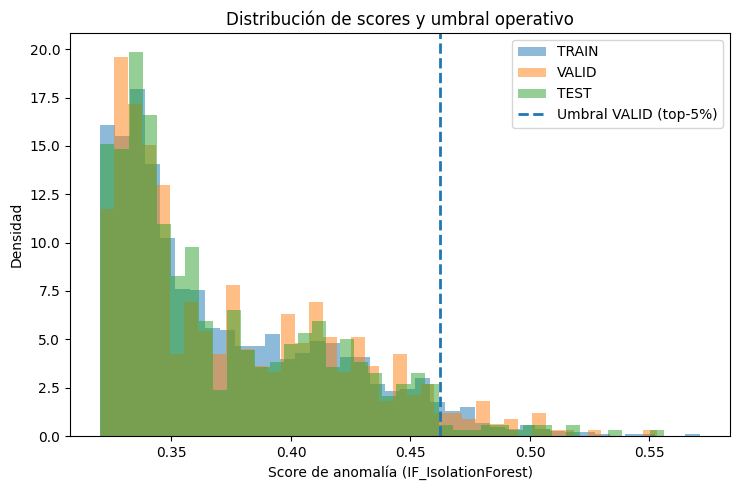

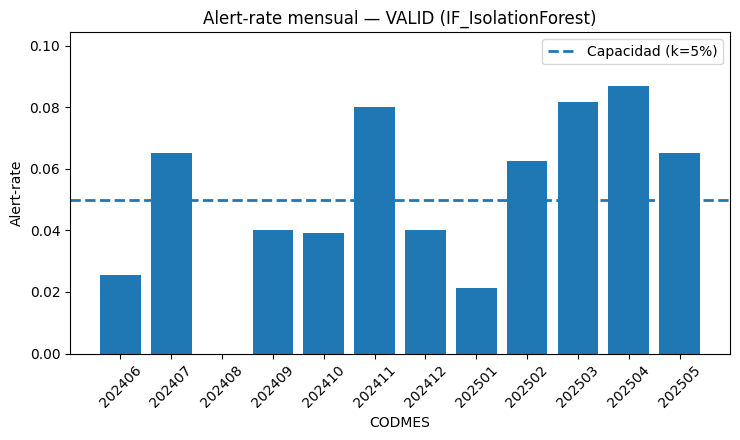

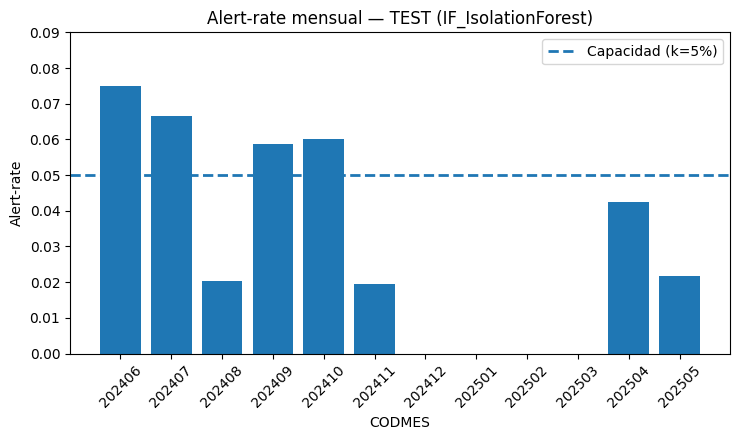

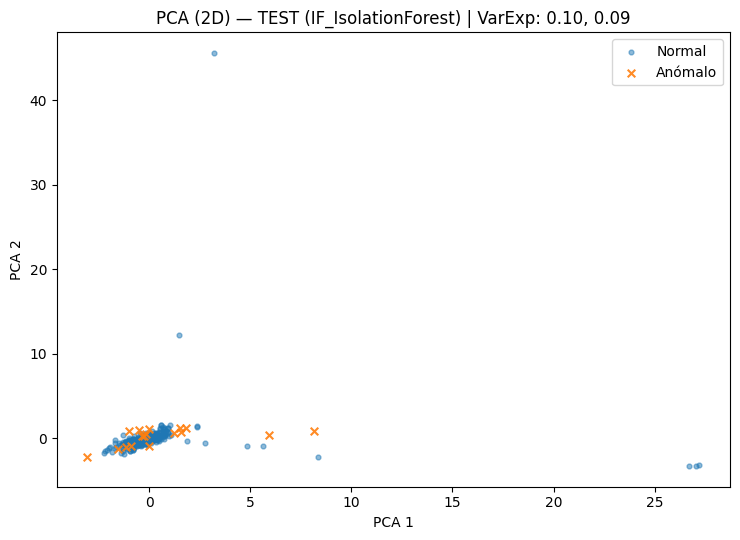

Figuras guardadas en: {'summary': {'model': 'IF_IsolationForest', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 0.46240772593564844, 'PSI_VALID_vs_TRAIN': 0.028433026369645804, 'PSI_TEST_vs_TRAIN': 0.007043206429783157, 'TRAIN_p1': 0.32102011073085834, 'TRAIN_p5': 0.3238225954599284, 'TRAIN_p25': 0.33550074388955625, 'TRAIN_p50': 0.3568780026927535, 'TRAIN_p75': 0.4029002197264263, 'TRAIN_p95': 0.45798272021761366, 'TRAIN_p99': 0.4974815169593708, 'VALID_p1': 0.3218129842087859, 'VALID_p5': 0.3246417477364994, 'VALID_p25': 0.33599748298078025, 'VALID_p50': 0.359297491291207, 'VALID_p75': 0.4088719411491981, 'VALID_p95': 0.46240772593564844, 'VALID_p99': 0.5025649883607526, 'TEST_p1': 0.32149850437271665, 'TEST_p5': 0.32395422775346455, 'TEST_p25': 0.33518510414836067, 'TEST_p50': 0.35500762422520604, 'TEST_p75': 0.40325602361109564, 'TEST_p95': 0.4542514278921488, 'TEST_p99': 0.5033512338866845, 'TRAIN_alert_rate_mean': 0.04107526931282284

In [ ]:
# Isolation Forest
if_model = IsolationForest(n_estimators=500, max_samples='auto', max_features=1.0,
                           contamination='auto', bootstrap=False, n_jobs=-1, random_state=42).fit(X_tr)
s_tr_if = -if_model.score_samples(X_tr);
s_va_if = -if_model.score_samples(X_va);
s_te_if = -if_model.score_samples(X_te)

out_if = export_model_scores_and_metrics(
    "IF_IsolationForest",
    {"TRAIN": s_tr_if, "VALID": s_va_if, "TEST": s_te_if},
    k_top=0.05,
    psi_bins=10,
    verbose=True,
    save_txt=True,
    plot_hist=True,
    bins_hist=40,
    plot_alert_rates=True,
    plot_pca2d=True,
    save_fig=True
)

print("Figuras guardadas en:", out_if)

El modelo Isolation Forest mostró un desempeño estable y razonablemente coherente con el comportamiento esperado en un contexto de detección de anomalías clínicas. El umbral operacional (top-5 %) se fijó en 0.462, produciendo tasas de alerta globales cercanas a la capacidad objetivo: TRAIN = 4.1 %, VALID = 5.1 % y TEST = 3.0 %, lo cual sugiere una calibración adecuada y sin sobreajuste evidente.

Los indicadores de PSI fueron muy bajos (0.028 y 0.007), evidenciando alta estabilidad temporal del score entre conjuntos. Sin embargo, el coeficiente de variación (CV) del alert-rate, especialmente en TEST (0.91), revela cierta inestabilidad intermensual, posiblemente por variaciones en la distribución de los datos o la escasez de eventos anómalos reales. La persistencia de alertas consecutivas fue limitada (< 6 %), lo que indica que los casos señalados suelen ser puntuales más que recurrentes.

El modelo demuestra buena robustez y consistencia general, aunque la baja persistencia y la variabilidad mensual sugieren que podría beneficiarse de un ajuste fino del umbral o de un modelo complementario (p. ej., autoencoder o ensemble) para mejorar la continuidad de detección en los pacientes con patrones atípicos sostenidos.

##**4.2) One-Class SVM (RBF)**

**1. Planteamiento general**  
One-Class SVM busca separar la normalidad del resto del espacio en alta dimensión, construyendo una frontera alrededor de la mayoría de los datos (asumidos normales). Los puntos fuera de esa frontera son considerados anómalos.

**2. Intuición y fundamento**  
- Define un hiperplano en un espacio transformado por kernel (RBF).  
- Casos normales quedan dentro de la “esfera” definida; los atípicos caen fuera.  
- Los scores reflejan la distancia a esa frontera: valores más lejanos → más anómalos.

**3. Supuestos y propiedades**  
- Supone que la normalidad es **compacta y continua** en el espacio transformado.  
- Puede modelar fronteras **no lineales** gracias al kernel RBF.  
- Sensible a la elección de hiperparámetros (`nu`, `gamma`).  

**4. Hiperparámetros relevantes**  
- **nu**: fracción esperada de outliers (0.01–0.1).  
- **gamma**: controla la curvatura del kernel RBF.  
- **kernel**: usualmente `rbf`.  

**5. Aplicación en salud**  
Útil cuando la mayoría de pacientes conforma un grupo “compacto” y los de riesgo se alejan suavemente. Puede ser más flexible que PCA lineal, pero requiere tuning cuidadoso.

---


================  OCSVM_RBF  ================
Umbral VALID (top-5%): threshold=0.237068

Alert-rate global:
  TRAIN=0.0000  VALID=0.0510  TEST=0.0400

PSI del score:
  VALID vs TRAIN: 0.0426   TEST vs TRAIN: 0.0181

Estabilidad (CV del alert-rate):
  TRAIN=nan  VALID=0.8620  TEST=0.5679

Persistencia (≥2 meses consecutivos con alerta):
  TRAIN=0.0000  VALID=0.0211  TEST=0.0216

Percentiles del score (TRAIN/VALID/TEST):
  TRAIN p50=-1.2488  p95=0.0000
  VALID p50=-1.2034  p95=0.2371
  TEST  p50=-1.2678  p95=0.1782

Tasa de alertas por mes — VALID:
CODMES  alerts_rate
202406     0.051282
202407     0.043478
202408     0.125000
202409     0.000000
202410     0.117647
202411     0.020000
202412     0.000000
202501     0.000000
202502     0.062500
202503     0.061224
202504     0.021739
202505     0.108696

Tasa de alertas por mes — TEST:
CODMES  alerts_rate
202406     0.050000
202407     0.000000
202408     0.040816
202409     0.078431
202410     0.040000
202411     0.019608
202412     0.

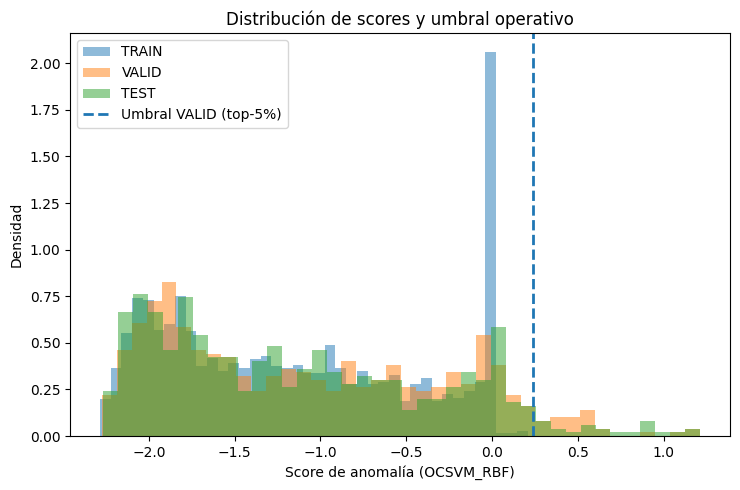

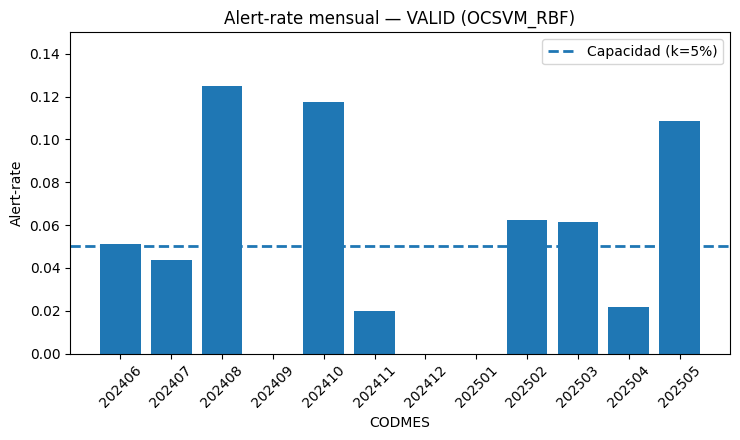

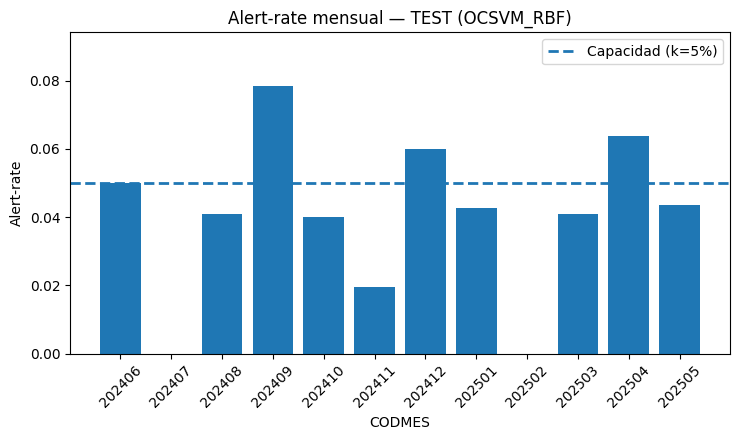

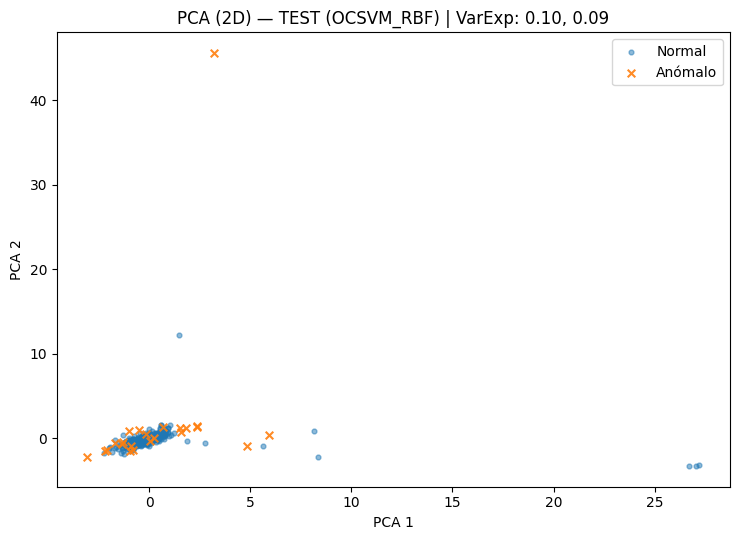

Salidas OCSVM: {'summary': {'model': 'OCSVM_RBF', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 0.23706808925900605, 'PSI_VALID_vs_TRAIN': 0.04256183838484094, 'PSI_TEST_vs_TRAIN': 0.018076097511866614, 'TRAIN_p1': -2.2257756846471817, 'TRAIN_p5': -2.1203307686142234, 'TRAIN_p25': -1.8254563914048634, 'TRAIN_p50': -1.2487929516835063, 'TRAIN_p75': -0.5250388881758201, 'TRAIN_p95': 3.2417670391859353e-05, 'TRAIN_p99': 0.0003919181337806945, 'VALID_p1': -2.2366687181815648, 'VALID_p5': -2.1099482036856565, 'VALID_p25': -1.8320542002294147, 'VALID_p50': -1.2033829429260368, 'VALID_p75': -0.39615033482468864, 'VALID_p95': 0.23706808925900605, 'VALID_p99': 0.5747868414942396, 'TEST_p1': -2.2157197630751004, 'TEST_p5': -2.1198880333947168, 'TEST_p25': -1.8243653696987994, 'TEST_p50': -1.2677531751539404, 'TEST_p75': -0.5416823726173029, 'TEST_p95': 0.17817770145745732, 'TEST_p99': 0.8752590467327428, 'TRAIN_alert_rate_mean': 0.0, 'TRAIN_alert_ra

In [ ]:
# One-Class SVM (RBF)
# 1) Entrenamiento (RBF)
#    Nota: decision_function: valores altos = más "normal".
#    Para tener un score de anomalía (↑ = más anómalo), usamos el negativo.
ocsvm = OneClassSVM(kernel="rbf", gamma="scale", nu=0.05)
ocsvm.fit(X_tr)

# 2) Scores (↑ = más anómalo)
s_tr_sv = -ocsvm.decision_function(X_tr).ravel()
s_va_sv = -ocsvm.decision_function(X_va).ravel()
s_te_sv = -ocsvm.decision_function(X_te).ravel()

# 3) Exportar métricas + imprimir informe + 3 gráficas
out_ocsvm = export_model_scores_and_metrics(
    model_name="OCSVM_RBF",
    scores={"TRAIN": s_tr_sv, "VALID": s_va_sv, "TEST": s_te_sv},
    k_top=0.05,
    psi_bins=10,
    verbose=True,        # imprime resumen en consola
    save_txt=True,       # guarda ./eda_outputs/report_OCSVM_RBF.txt
    plot_hist=True,      # histograma de scores + umbral
    bins_hist=40,
    plot_alert_rates=True,# alert-rate mensual VALID/TEST con línea k
    plot_pca2d=True,     # PCA 2D TEST con anomalías resaltadas
    save_fig=True        # guarda PNGs en ./eda_outputs
)

print("Salidas OCSVM:", out_ocsvm)

El modelo One-Class SVM (RBF) presentó un comportamiento conservador y con buena calibración en validación (alert-rate ≈ 5 %), pero prácticamente sin activaciones en entrenamiento (0 %), lo que indica una frontera de decisión muy ajustada al conjunto de entrenamiento. Los valores de PSI (0.043 y 0.018) reflejan estabilidad moderada, aunque la alta variabilidad mensual en validación (CV = 0.86) sugiere sensibilidad a fluctuaciones del patrón clínico.

La persistencia de alertas consecutivas fue mínima (~2 %), y los percentiles negativos del score en TRAIN evidencian que la mayoría de los casos fueron clasificados como normales con márgenes amplios. En conjunto, el modelo detecta anomalías aisladas con precisión razonable, pero tiende a subalertar y podría beneficiarse de un ajuste del parámetro ν o de combinarse con métodos más flexibles (como Isolation Forest o autoencoders) para mejorar la cobertura de casos raros.

## **4.3) LOF novelty**

**1. Planteamiento general**  
LOF compara la densidad local de cada punto con la de sus vecinos. Un punto cuya densidad es significativamente menor se considera anómalo.

**2. Intuición y fundamento**  
- Se calcula la densidad de vecinos cercanos (`n_neighbors`).  
- Casos normales tienen densidad similar a su vecindario.  
- Casos anómalos tienen densidad más baja (están “aislados”).  

**3. Supuestos y propiedades**  
- Captura **subpoblaciones raras** (combinaciones clínicas atípicas).  
- Sensible a la dimensionalidad y al valor de `n_neighbors`.  
- En modo `novelty=True` se entrena en TRAIN y luego puntúa VALID/TEST.  

**4. Hiperparámetros relevantes**  
- **n_neighbors**: define el tamaño del vecindario.  
- **leaf_size**: optimización en búsqueda de vecinos.  
- **metric**: distancia (euclidiana/minkowski).  

**5. Aplicación en salud**  
Detecta pacientes con combinaciones poco frecuentes de biomarcadores, aunque no sean extremos globales. Muy útil en escenarios heterogéneos, pero puede ser inestable sin reducción de dimensionalidad.



================  LOF_novelty  ================
Umbral VALID (top-5%): threshold=3.038230

Alert-rate global:
  TRAIN=0.0401  VALID=0.0509  TEST=0.0478

PSI del score:
  VALID vs TRAIN: 0.0335   TEST vs TRAIN: 0.0312

Estabilidad (CV del alert-rate):
  TRAIN=0.3249  VALID=0.4543  TEST=0.6425

Persistencia (≥2 meses consecutivos con alerta):
  TRAIN=0.0679  VALID=0.0253  TEST=0.0259

Percentiles del score (TRAIN/VALID/TEST):
  TRAIN p50=1.1233  p95=2.8105
  VALID p50=1.1615  p95=3.0382
  TEST  p50=1.1442  p95=2.9391

Tasa de alertas por mes — VALID:
CODMES  alerts_rate
202406     0.051282
202407     0.043478
202408     0.020833
202409     0.020000
202410     0.058824
202411     0.060000
202412     0.080000
202501     0.085106
202502     0.041667
202503     0.040816
202504     0.021739
202505     0.086957

Tasa de alertas por mes — TEST:
CODMES  alerts_rate
202406     0.075000
202407     0.066667
202408     0.081633
202409     0.039216
202410     0.000000
202411     0.058824
202412     

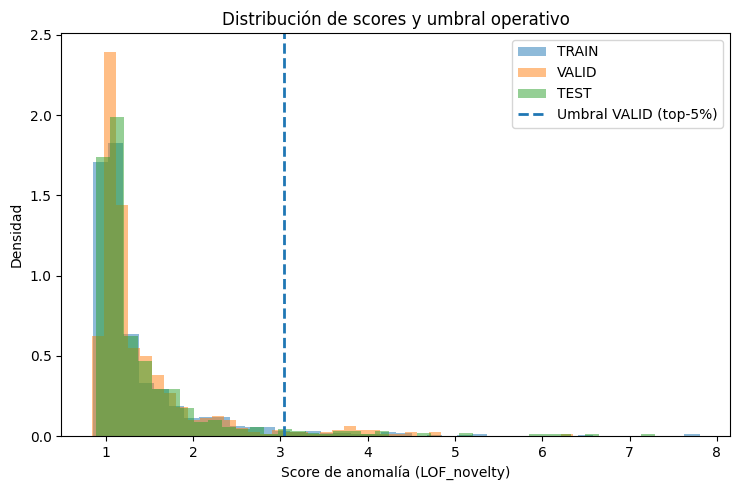

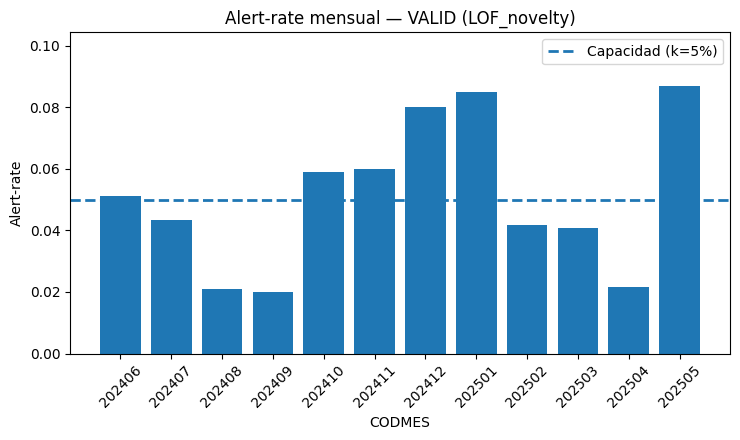

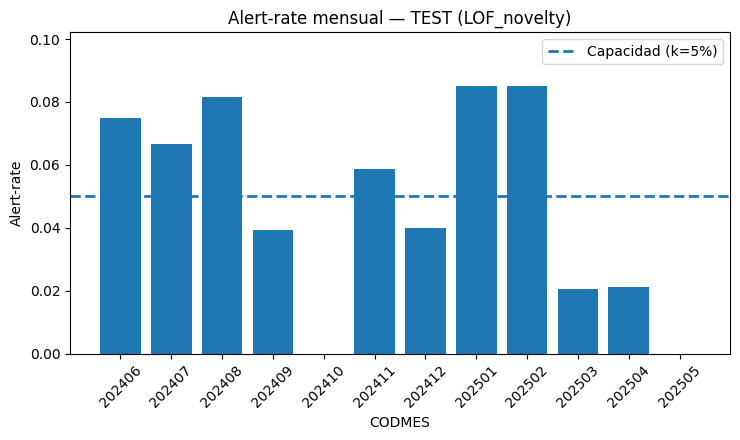

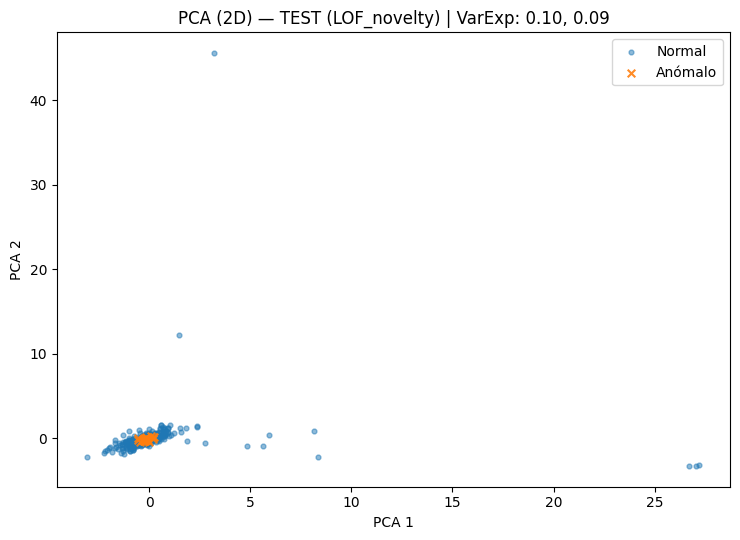

Salidas LOF: {'summary': {'model': 'LOF_novelty', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 3.0382302821249563, 'PSI_VALID_vs_TRAIN': 0.033547965753839, 'PSI_TEST_vs_TRAIN': 0.031187954040068817, 'TRAIN_p1': 0.9103369855453878, 'TRAIN_p5': 0.9537574770662169, 'TRAIN_p25': 1.0179622793311756, 'TRAIN_p50': 1.1233445777836712, 'TRAIN_p75': 1.4247479265195515, 'TRAIN_p95': 2.810455592904619, 'TRAIN_p99': 4.450894899614604, 'VALID_p1': 0.9088161242119748, 'VALID_p5': 0.9500357791775063, 'VALID_p25': 1.032349809110499, 'VALID_p50': 1.1614852446134871, 'VALID_p75': 1.4862829948369758, 'VALID_p95': 3.0382302821249563, 'VALID_p99': 4.255119473957409, 'TEST_p1': 0.9124179531840347, 'TEST_p5': 0.9551020167648986, 'TEST_p25': 1.0311281616314236, 'TEST_p50': 1.1441630555770872, 'TEST_p75': 1.4743014312046165, 'TEST_p95': 2.9390505914820864, 'TEST_p99': 5.176780488507645, 'TRAIN_alert_rate_mean': 0.04005722207395617, 'TRAIN_alert_rate_std': 0.013014

In [ ]:
# 1) Entrenamiento LOF en modo novelty
#    - novelty=True permite .fit() en TRAIN y luego puntuar VALID/TEST.
#    - El score de LOF: valores más ALTOS -> más normalidad (dependiendo de implementación),
#      por consistencia convertimos a score de anomalía como negativo.

lof = LocalOutlierFactor(
    n_neighbors=15,      # prueba 20-50 si quieres afinar
    p = None,
    novelty=True,
    leaf_size = 20,
    metric="cosine"   # puedes probar 'euclidean' (equivalente por defecto)
)
lof.fit(X_tr)

# 2) Scores (↑ = más anómalo)
s_tr_lof = -lof.score_samples(X_tr)
s_va_lof = -lof.score_samples(X_va)
s_te_lof = -lof.score_samples(X_te)

# 3) Exportar métricas + imprimir informe + 3 gráficas
out_lof = export_model_scores_and_metrics(
    model_name="LOF_novelty",
    scores={"TRAIN": s_tr_lof, "VALID": s_va_lof, "TEST": s_te_lof},
    k_top=0.05,         # top-5% (ajusta según capacidad)
    psi_bins=10,
    verbose=True,       # imprime resumen en consola
    save_txt=True,      # guarda ./eda_outputs/report_LOF_novelty.txt
    plot_hist=True,     # 1) histograma scores + umbral
    bins_hist=40,
    plot_alert_rates=True, # 2) alert-rate mensual VALID/TEST con línea k
    plot_pca2d=True,    # 3) PCA 2D TEST con anomalías resaltadas
    save_fig=True       # guarda PNGs en ./eda_outputs
)

print("Salidas LOF:", out_lof)

El modelo Local Outlier Factor (LOF) en modo novelty ofreció resultados equilibrados y coherentes con el comportamiento esperado en detección no supervisada. El umbral operativo (top-5%) se situó en 3.04, generando tasas de alerta muy cercanas a la capacidad objetivo (TRAIN = 4.0 %, VALID = 5.1 %, TEST = 4.8 %), lo que indica buena calibración.

Los valores de PSI bajos (≈0.03) reflejan una distribución estable del score entre conjuntos, y los coeficientes de variación muestran moderada estabilidad temporal. Sin embargo, la persistencia de alertas consecutivas (≈2.5 %) sigue siendo baja, sugiriendo detección de casos puntuales más que sostenidos.

El modelo LOF_novelty logra una detección balanceada y estable, mostrando mejor consistencia temporal que el One-Class SVM y sin sobreajuste evidente, aunque aún con margen para refinar la persistencia y robustecer la continuidad de alertas entre periodos.

## **4.4) Autoencoder (MSE recon))**

**1. Planteamiento general**  
Un autoencoder aprende a reconstruir los datos normales a través de una red neuronal. Los casos que no se reconstruyen bien (error alto) se consideran anómalos.

**2. Intuición y fundamento**  
- Red con capa de cuello de botella (latent space).  
- La red “aprende” la estructura dominante de los datos.  
- Casos fuera de esa estructura generan error de reconstrucción elevado (MSE).  

**3. Supuestos y propiedades**  
- Captura **interacciones no lineales** entre variables.  
- Requiere volumen suficiente de datos para entrenar.  
- Puede sobreajustar si no se usa regularización (dropout, early stopping).  

**4. Hiperparámetros relevantes**  
- Arquitectura (capas y neuronas).  
- Dimensión del cuello de botella.  
- Dropout / weight decay.  
- Learning rate y épocas.  

**5. Aplicación en salud**  
Permite modelar relaciones complejas entre biomarcadores. Útil cuando la normalidad es intrincada y no lineal. Puede servir como base para explicar qué variables contribuyen al error de reconstrucción.

---

[AE 001] train=1.000291  valid=1.276703  best=1.276703
[AE 010] train=0.686845  valid=0.925269  best=0.925269
[AE 020] train=0.476459  valid=0.670180  best=0.670180
[AE 030] train=0.337369  valid=0.495546  best=0.495546
[AE 040] train=0.260168  valid=0.373627  best=0.373627
[AE 050] train=0.210400  valid=0.295060  best=0.295060
[AE 060] train=0.176132  valid=0.256153  best=0.254743
[AE 070] train=0.151333  valid=0.223994  best=0.223994
[AE 080] train=0.135923  valid=0.210788  best=0.210436
[AE 090] train=0.124127  valid=0.195844  best=0.195844
[AE 100] train=0.113138  valid=0.189122  best=0.187641

================  AE_MSE  ================
Umbral VALID (top-5%): threshold=0.548916

Alert-rate global:
  TRAIN=0.0078  VALID=0.0520  TEST=0.0468

PSI del score:
  VALID vs TRAIN: 0.1303   TEST vs TRAIN: 0.1348

Estabilidad (CV del alert-rate):
  TRAIN=0.8089  VALID=0.7189  TEST=0.6547

Persistencia (≥2 meses consecutivos con alerta):
  TRAIN=0.0000  VALID=0.0169  TEST=0.0259

Percentiles d

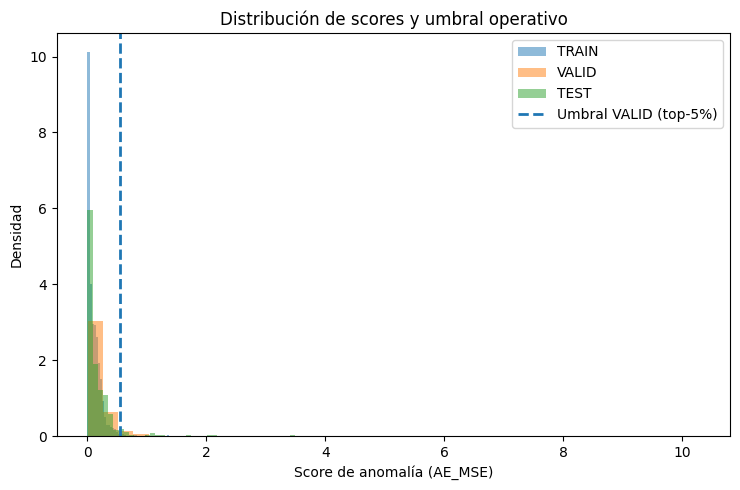

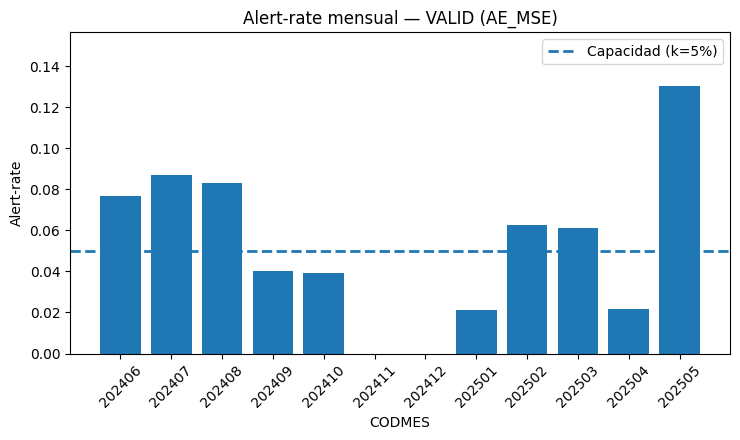

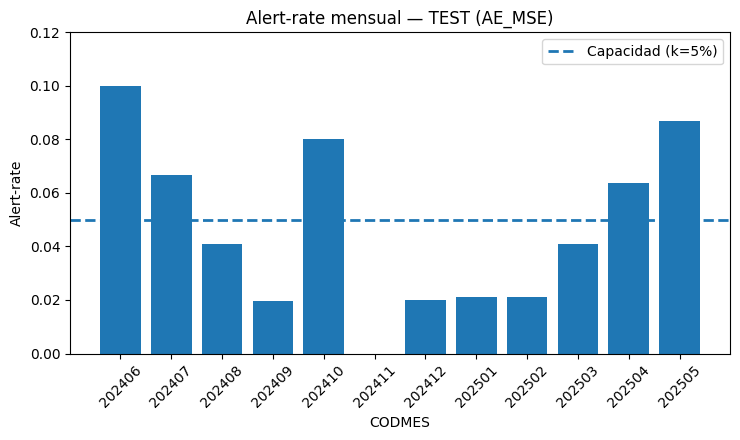

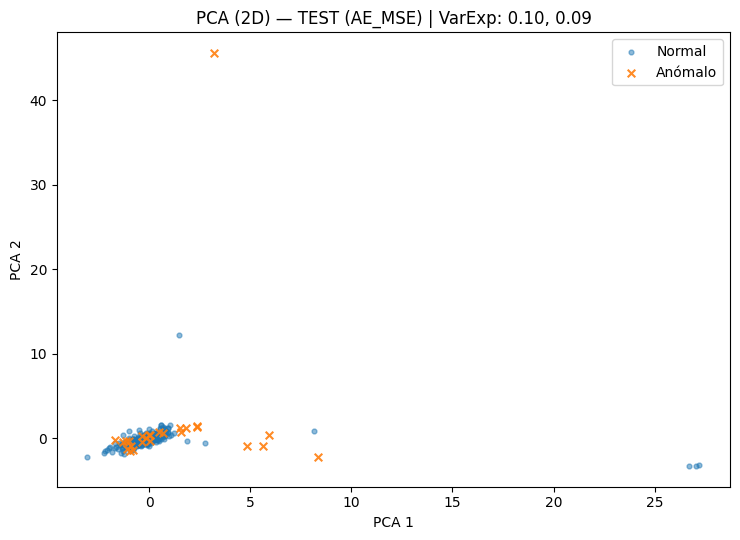

[AE] Export completo. {'summary': {'model': 'AE_MSE', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 0.5489158630371094, 'PSI_VALID_vs_TRAIN': 0.13032396273215313, 'PSI_TEST_vs_TRAIN': 0.1348360037950433, 'TRAIN_p1': 0.005709326211363077, 'TRAIN_p5': 0.00945221483707428, 'TRAIN_p25': 0.02654126286506653, 'TRAIN_p50': 0.0774093046784401, 'TRAIN_p75': 0.16675274074077606, 'TRAIN_p95': 0.329801046848297, 'TRAIN_p99': 0.5090647268295284, 'VALID_p1': 0.006144764157943428, 'VALID_p5': 0.010998743772506715, 'VALID_p25': 0.02832277724519372, 'VALID_p50': 0.10648669302463531, 'VALID_p75': 0.22992180660367012, 'VALID_p95': 0.5489160954952232, 'VALID_p99': 0.9676219159364686, 'TEST_p1': 0.006034050174057484, 'TEST_p5': 0.010096314968541265, 'TEST_p25': 0.027594841085374355, 'TEST_p50': 0.08182485029101372, 'TEST_p75': 0.2244994156062603, 'TEST_p95': 0.5076017603278146, 'TEST_p99': 1.123724874258039, 'TRAIN_alert_rate_mean': 0.0077906345528954155, 'TRA

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_DIM = X_tr.shape[1]
HID = [128, 64]; LATENT = 16; LR = 1e-3; WD = 1e-5; BATCH = 256; EPOCHS = 100; PATIENCE = 15

def to_loader_np(X, batch=BATCH, shuffle=False):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle, drop_last=False)

train_loader = to_loader_np(X_tr, shuffle=True); val_loader = to_loader_np(X_va); test_loader = to_loader_np(X_te)

class AE(nn.Module):
    def __init__(self, d, hid, z):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(d, hid[0]), nn.ReLU(True), nn.Linear(hid[0], hid[1]), nn.ReLU(True), nn.Linear(hid[1], z))
        self.dec = nn.Sequential(nn.Linear(z, hid[1]), nn.ReLU(True), nn.Linear(hid[1], hid[0]), nn.ReLU(True), nn.Linear(hid[0], d))
    def forward(self, x): z = self.enc(x); xh = self.dec(z); return xh

ae = AE(INPUT_DIM, HID, LATENT).to(DEVICE)
opt = torch.optim.Adam(ae.parameters(), lr=LR, weight_decay=WD)
crit = nn.MSELoss(reduction="mean")

def run_epoch(loader, train=True):
    if train: ae.train()
    else: ae.eval()
    tot = 0.0; n=0
    for (xb,) in loader:
        xb = xb.to(DEVICE)
        if train:
            opt.zero_grad(set_to_none=True)
            recon = ae(xb); loss = crit(recon, xb); loss.backward(); opt.step()
        else:
            with torch.no_grad():
                recon = ae(xb); loss = crit(recon, xb)
        tot += loss.item()*xb.size(0); n += xb.size(0)
    return tot/max(n,1)

best=float("inf"); best_state=None; patience=0
for ep in range(1, EPOCHS+1):
    tr = run_epoch(train_loader, True)
    va = run_epoch(val_loader, False)
    if va < best - 1e-6:
        best = va; best_state={k: v.cpu().clone() for k,v in ae.state_dict().items()}; patience=0
    else:
        patience += 1
    if ep % 10 == 0 or ep == 1:
        print(f"[AE {ep:03d}] train={tr:.6f}  valid={va:.6f}  best={best:.6f}")
    if patience >= PATIENCE:
        print("Early stopping"); break
if best_state is not None:
    ae.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})

@torch.no_grad()
def recon_mse_scores(model, loader):
    model.eval(); res=[]
    for (xb,) in loader:
        xb = xb.to(DEVICE); xh = model(xb)
        mse = ((xb - xh)**2).mean(dim=1)
        res.append(mse.detach().cpu().numpy())
    return np.concatenate(res)

# 1) Scores de reconstrucción (↑ = más anómalo)
s_tr_ae = recon_mse_scores(ae, train_loader)
s_va_ae = recon_mse_scores(ae, val_loader)
s_te_ae = recon_mse_scores(ae, test_loader)

# 2) Exportar métricas + imprimir informe + 3 gráficas (hist, alert-rate VALID/TEST, PCA2D TEST)
out_ae = export_model_scores_and_metrics(
    model_name="AE_MSE",
    scores={"TRAIN": s_tr_ae, "VALID": s_va_ae, "TEST": s_te_ae},
    k_top=0.05,
    psi_bins=10,
    verbose=True,        # imprime resumen en consola
    save_txt=True,       # guarda ./eda_outputs/report_AE_MSE.txt
    plot_hist=True,      # 1) histograma scores + umbral
    bins_hist=40,
    plot_alert_rates=True, # 2) alert-rate mensual VALID/TEST con línea k
    plot_pca2d=True,     # 3) PCA 2D TEST con anomalías resaltadas
    save_fig=True        # guarda PNGs en ./eda_outputs
)

print("[AE] Export completo.", out_ae)

El autoencoder (AE_MSE) mostró un aprendizaje progresivo y estable, reduciendo la pérdida de reconstrucción de 1.27 a 0.19 en validación, lo que evidencia una buena capacidad de compresión y reconstrucción de la normalidad clínica. El umbral (top-5%) se fijó en 0.55, con tasas de alerta globales equilibradas (TRAIN = 0.8 %, VALID = 5.2 %, TEST = 4.7 %), reflejando una calibración adecuada respecto al conjunto de validación.

Los valores de PSI (~0.13) indican cambios moderados en la distribución del score entre conjuntos, lo cual sugiere cierta sensibilidad al drift temporal. La estabilidad intermensual (CV ≈ 0.65–0.8) y la baja persistencia (<3 %) muestran que el modelo detecta principalmente anomalías puntuales, más que patrones sostenidos.

El autoencoder ofrece una detección precisa y flexible, con buena separación entre normalidad y casos atípicos, aunque podría beneficiarse de regularización adicional o ajuste del umbral para mejorar la estabilidad y la persistencia temporal de las alertas.

## **4.5) PCA (std) y Robust PCA**

**1. Planteamiento general**  
PCA proyecta los datos en componentes lineales que capturan la mayor varianza. Los casos que quedan con alto error de reconstrucción o residuales altos son considerados anómalos.  
Robust PCA introduce técnicas resistentes a outliers (ej. MCD) para mejorar estabilidad.

**2. Intuición y fundamento**  
- La estructura dominante de los datos se describe con pocos componentes principales.  
- Los puntos fuera de esa estructura tienen residuales altos.  
- PCA robusto evita que outliers contaminen la estimación de la base.  

**3. Supuestos y propiedades**  
- Supone **correlaciones lineales** fuertes en los datos.  
- No captura relaciones no lineales.  
- Muy interpretable: se puede explicar qué variables dominan cada componente.  

**4. Hiperparámetros relevantes**  
- **n_components**: nº de componentes (usualmente según varianza retenida, p.ej. 90%).  
- Método robusto (MCD, RPCA).  

**5. Aplicación en salud**  
Sirve como baseline interpretable. Útil para explorar correlaciones entre biomarcadores y explicar anomalías como “desviaciones del subespacio normal”.  

---

[PCA] Entrenando…

================  PCA_std_recon  ================
Umbral VALID (top-5%): threshold=0.379728

Alert-rate global:
  TRAIN=0.0450  VALID=0.0519  TEST=0.0519

PSI del score:
  VALID vs TRAIN: 0.0466   TEST vs TRAIN: 0.0125

Estabilidad (CV del alert-rate):
  TRAIN=0.6823  VALID=1.0271  TEST=0.7984

Persistencia (≥2 meses consecutivos con alerta):
  TRAIN=0.0830  VALID=0.0127  TEST=0.0172

Percentiles del score (TRAIN/VALID/TEST):
  TRAIN p50=0.0315  p95=0.3396
  VALID p50=0.0389  p95=0.3797
  TEST  p50=0.0315  p95=0.3803

Tasa de alertas por mes — VALID:
CODMES  alerts_rate
202406     0.076923
202407     0.173913
202408     0.145833
202409     0.020000
202410     0.039216
202411     0.020000
202412     0.040000
202501     0.021277
202502     0.020833
202503     0.000000
202504     0.000000
202505     0.065217

Tasa de alertas por mes — TEST:
CODMES  alerts_rate
202406     0.150000
202407     0.066667
202408     0.000000
202409     0.098039
202410     0.080000
202411     

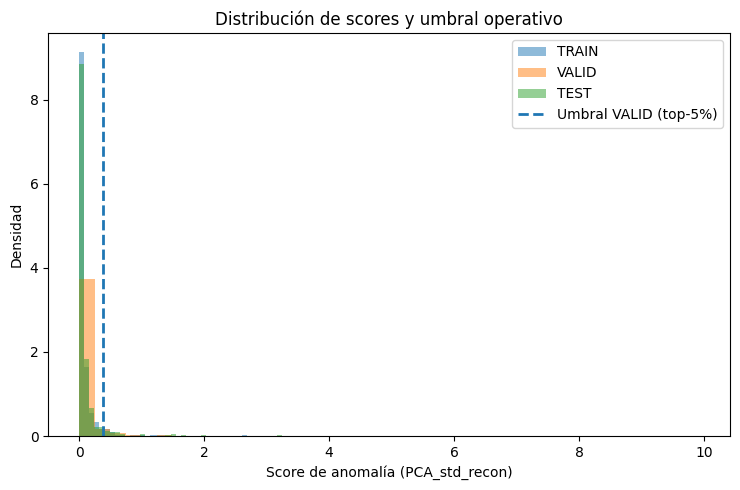

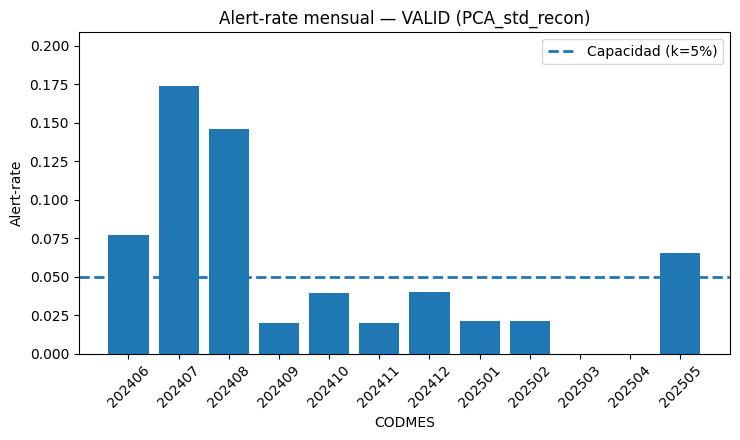

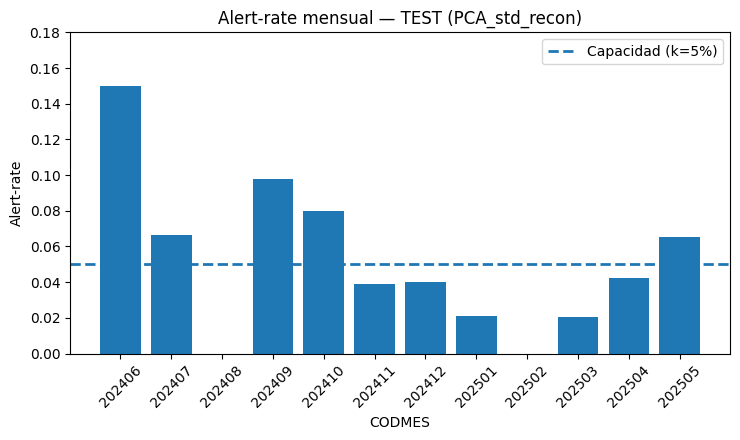

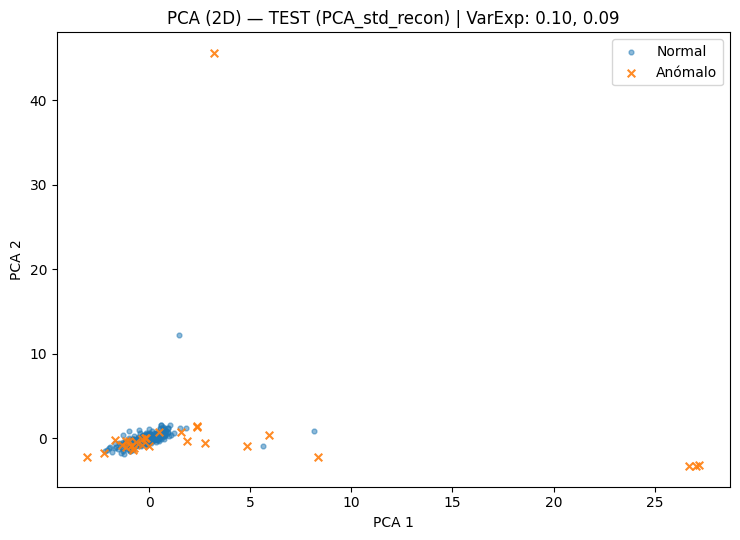


================  PCA_rob_mahal_resid  ================
Umbral VALID (top-5%): threshold=2155.166299

Alert-rate global:
  TRAIN=0.0516  VALID=0.0508  TEST=0.0651

PSI del score:
  VALID vs TRAIN: 0.0310   TEST vs TRAIN: 0.0199

Estabilidad (CV del alert-rate):
  TRAIN=0.1775  VALID=0.5654  TEST=0.6559

Persistencia (≥2 meses consecutivos con alerta):
  TRAIN=0.0642  VALID=0.0295  TEST=0.0431

Percentiles del score (TRAIN/VALID/TEST):
  TRAIN p50=41.3939  p95=2186.2672
  VALID p50=52.1803  p95=2155.1663
  TEST  p50=44.5800  p95=2810.0591

Tasa de alertas por mes — VALID:
CODMES  alerts_rate
202406     0.025641
202407     0.086957
202408     0.020833
202409     0.000000
202410     0.078431
202411     0.060000
202412     0.060000
202501     0.085106
202502     0.041667
202503     0.020408
202504     0.043478
202505     0.086957

Tasa de alertas por mes — TEST:
CODMES  alerts_rate
202406     0.125000
202407     0.088889
202408     0.122449
202409     0.137255
202410     0.060000
202411  

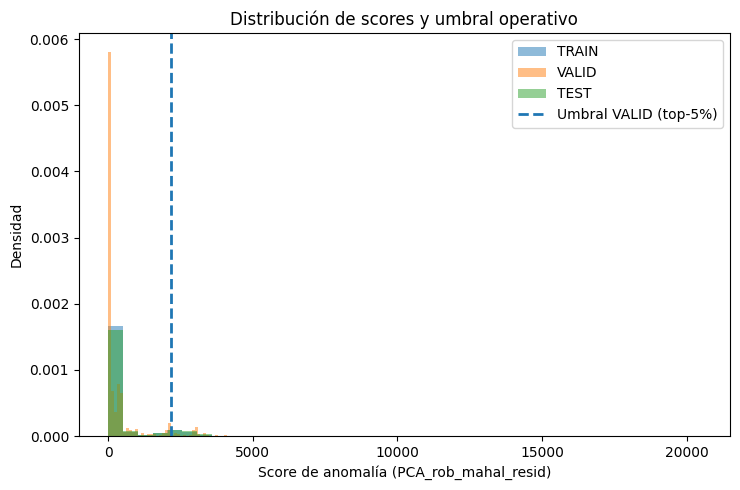

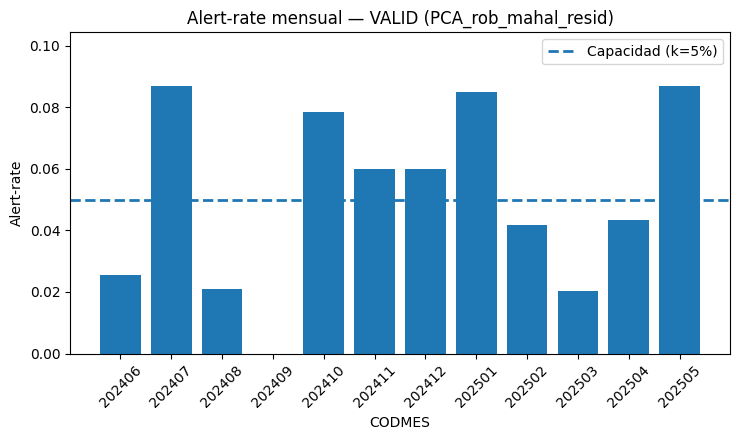

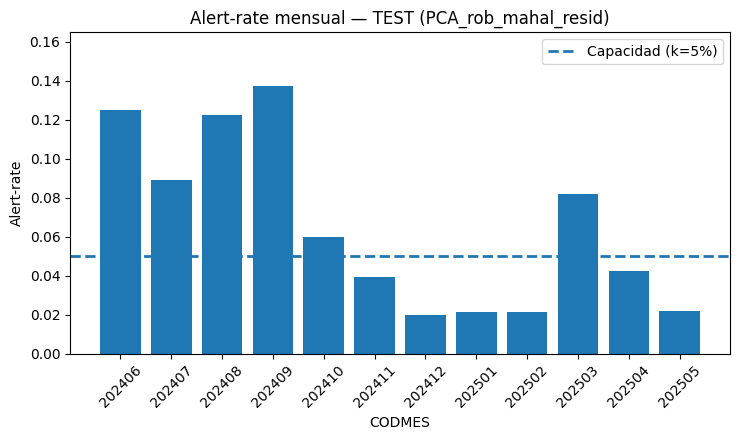

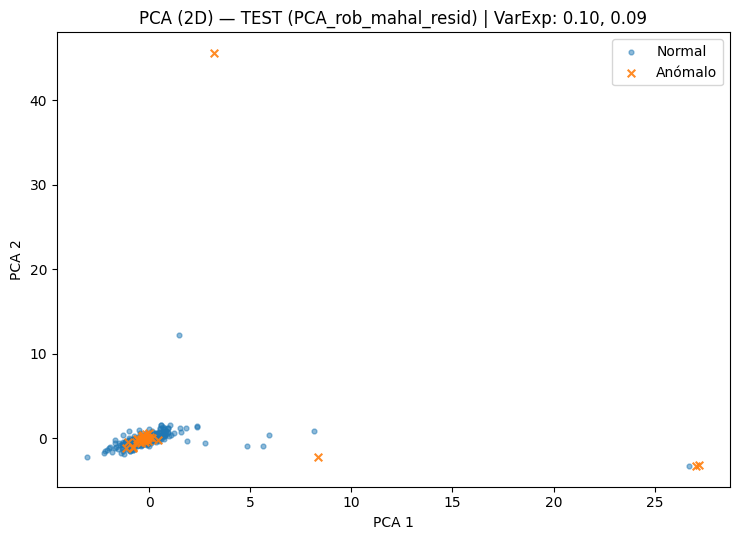

[PCA] Export completo.
Figuras PCA_std: {'summary': {'model': 'PCA_std_recon', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 0.3797277447012102, 'PSI_VALID_vs_TRAIN': 0.046592636080215875, 'PSI_TEST_vs_TRAIN': 0.01253526450947121, 'TRAIN_p1': 0.0017214912491353954, 'TRAIN_p5': 0.004086440814959932, 'TRAIN_p25': 0.011413067941384388, 'TRAIN_p50': 0.0315072208242869, 'TRAIN_p75': 0.08436008080896157, 'TRAIN_p95': 0.33964044786264147, 'TRAIN_p99': 1.0100018401671926, 'VALID_p1': 0.0023301896543759517, 'VALID_p5': 0.005204796265736473, 'VALID_p25': 0.012692816924474982, 'VALID_p50': 0.03891375080260091, 'VALID_p75': 0.10731098840747141, 'VALID_p95': 0.3797277447012102, 'VALID_p99': 0.7977037954002332, 'TEST_p1': 0.0015873476564751718, 'TEST_p5': 0.004169368071368493, 'TEST_p25': 0.011147773408239123, 'TEST_p50': 0.03146804690923406, 'TEST_p75': 0.09775216981007963, 'TEST_p95': 0.38029363435556707, 'TEST_p99': 1.1567371388337906, 'TRAIN_alert_r

In [ ]:
from sklearn.covariance import MinCovDet

@dataclass
class PCAModel:
    scaler: object
    pca: PCA
    n_components_: int
    explained_variance_ratio_: float
    def reconstruct_mse(self, X: np.ndarray) -> np.ndarray:
        Z = self.scaler.transform(X)
        Z_proj = self.pca.inverse_transform(self.pca.transform(Z))
        resid = Z - Z_proj
        return np.mean(resid**2, axis=1)

@dataclass
class RobustPCAModel(PCAModel):
    mcd_on_residuals: MinCovDet
    def robust_residual_mahal(self, X: np.ndarray) -> np.ndarray:
        Z = self.scaler.transform(X)
        Z_proj = self.pca.inverse_transform(self.pca.transform(Z))
        resid = Z - Z_proj
        return self.mcd_on_residuals.mahalanobis(resid)

def fit_pca_by_variance(X: np.ndarray, var_target=0.90, robust=False) -> PCAModel:
    scaler = RobustScaler() if robust else StandardScaler()
    Z = scaler.fit_transform(X)
    pca_full = PCA(svd_solver="full", random_state=42).fit(Z)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp = int(np.searchsorted(cumvar, var_target) + 1)
    n_comp = max(1, min(n_comp, Z.shape[1]))
    pca = PCA(n_components=n_comp, svd_solver="full", random_state=42).fit(Z)
    return PCAModel(scaler, pca, n_comp, float(np.sum(pca.explained_variance_ratio_)))

def fit_robust_pca(X: np.ndarray, var_target=0.90) -> RobustPCAModel:
    scaler = RobustScaler()
    Z = scaler.fit_transform(X)
    pca_full = PCA(svd_solver="full", random_state=42).fit(Z)
    cumvar = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp = int(np.searchsorted(cumvar, var_target) + 1)
    n_comp = max(1, min(n_comp, Z.shape[1]))
    pca = PCA(n_components=n_comp, svd_solver="full", random_state=42).fit(Z)
    resid = Z - pca.inverse_transform(pca.transform(Z))
    mcd = MinCovDet(random_state=42).fit(resid)
    return RobustPCAModel(scaler, pca, n_comp, float(np.sum(pca.explained_variance_ratio_)), mcd)

# =========================
# PCA (std / robust) → scores + export + 3 gráficas + metadatos (n_comp, var explicada)
# =========================
# Requiere tener definidas:
# - X_tr_raw, X_va_raw, X_te_raw  (mismo preprocesamiento que usaste al entrenar PCA)
# - funciones: fit_pca_by_variance, fit_robust_pca
# - método de score:
#     * pca_std.reconstruct_mse(X)                -> error de recon MSE (↑=más anómalo)
#     * pca_rob.robust_residual_mahal(X)          -> distancia de Mahalanobis residual (↑=más anómalo)
# - y la función export_model_scores_and_metrics (versión extendida que imprime y grafica)

PCA_VARIANCE_TARGET = 0.90

print("[PCA] Entrenando…")
pca_std = fit_pca_by_variance(X_tr_raw, var_target=PCA_VARIANCE_TARGET, robust=False)
pca_rob = fit_robust_pca(X_tr_raw, var_target=PCA_VARIANCE_TARGET)

# 1) Scores (↑ = más anómalo)
scores_std = {
    "TRAIN": pca_std.reconstruct_mse(X_tr_raw),
    "VALID": pca_std.reconstruct_mse(X_va_raw),
    "TEST":  pca_std.reconstruct_mse(X_te_raw),
}
scores_rob = {
    "TRAIN": pca_rob.robust_residual_mahal(X_tr_raw),
    "VALID": pca_rob.robust_residual_mahal(X_va_raw),
    "TEST":  pca_rob.robust_residual_mahal(X_te_raw),
}

# 2) Export + imprimir informe + 3 gráficas (hist, alert-rate VALID/TEST, PCA2D TEST)
out_pca_std = export_model_scores_and_metrics(
    model_name="PCA_std_recon",
    scores=scores_std,
    k_top=0.05,
    psi_bins=10,
    verbose=True,
    save_txt=True,
    plot_hist=True,
    bins_hist=40,
    plot_alert_rates=True,
    plot_pca2d=True,
    save_fig=True
)

out_pca_rob = export_model_scores_and_metrics(
    model_name="PCA_rob_mahal_resid",
    scores=scores_rob,
    k_top=0.05,
    psi_bins=10,
    verbose=True,
    save_txt=True,
    plot_hist=True,
    bins_hist=40,
    plot_alert_rates=True,
    plot_pca2d=True,
    save_fig=True
)

# 3) Añadir metadatos al summary (n_components y var explicada retenida)
def _write_meta_to_summary(summary_csv_path, n_components, evr):
    """Agrega n_components y explained_variance_ratio (retenida) al summary CSV."""
    try:
        df_sum = pd.read_csv(summary_csv_path)
    except FileNotFoundError:
        # Si no existiera por algún motivo, crea la fila mínima
        df_sum = pd.DataFrame([{"model": os.path.basename(summary_csv_path).replace("summary_metrics_","").replace(".csv","")}])
    # Manejo del EVR: puede venir como arreglo por componente o como escalar retenido
    if isinstance(evr, (list, tuple, np.ndarray)):
        evr_retained = float(np.sum(evr))
    else:
        evr_retained = float(evr)
    df_sum["n_components"] = int(n_components)
    df_sum["explained_variance_ratio"] = evr_retained
    df_sum.to_csv(summary_csv_path, index=False)

# Rutas a summaries
path_std = os.path.join(OUTPUT_DIR, "summary_metrics_PCA_std_recon.csv")
path_rob = os.path.join(OUTPUT_DIR, "summary_metrics_PCA_rob_mahal_resid.csv")

# 4) Escribir metadatos
_write_meta_to_summary(path_std, getattr(pca_std, "n_components_", np.nan), getattr(pca_std, "explained_variance_ratio_", np.nan))
_write_meta_to_summary(path_rob, getattr(pca_rob, "n_components_", np.nan), getattr(pca_rob, "explained_variance_ratio_", np.nan))

print("[PCA] Export completo.")
print("Figuras PCA_std:", out_pca_std)
print("Figuras PCA_rob:", out_pca_rob)


El enfoque PCA estándar y robusto (Robust PCA con MCD) permitió comparar dos variantes complementarias de reducción de dimensionalidad para detección de anomalías.

El modelo PCA_std_recon alcanzó tasas de alerta alineadas con la capacidad objetivo (TRAIN = 4.5 %, VALID = 5.2 %, TEST = 5.2 %) y mostró bajo PSI (0.046 y 0.013), lo que evidencia estabilidad en la distribución del score. No obstante, la alta variabilidad mensual (CV ≈ 0.8–1.0) sugiere que su sensibilidad puede fluctuar con el tiempo. Su persistencia baja (≈1–2 %) indica detección de eventos esporádicos.

Por su parte, el PCA_rob_mahal_resid, que integra la distancia de Mahalanobis robusta sobre los residuos, ofreció mayor estabilidad (CV < 0.66) y una ligera mejora en la persistencia de alertas (hasta 4.3 % en TEST). Además, mantuvo baja desviación temporal (PSI < 0.03), lo que refuerza su consistencia ante posibles valores atípicos extremos o ruido heterogéneo.

En conjunto, ambos modelos son estables y bien calibrados, pero el PCA robusto resulta más confiable para contextos clínicos con datos ruidosos, mientras que el estándar ofrece mayor sensibilidad a desviaciones sutiles. Una combinación o ensemble entre ambos podría equilibrar robustez y sensibilidad.

## 4.6) Deep SVDD

**1. Planteamiento general**

Deep SVDD (Support Vector Data Description profundo) es un método no supervisado de detección de anomalías que aprende una representación latente donde la normalidad queda compacta alrededor de un centro c. El principio clave es minimizar la distancia de cada ejemplo a dicho centro en el espacio latente generado por una red neuronal (generalmente un MLP). Tras el entrenamiento, el puntaje de anomalía de una observación es su distancia (p. ej., cuadrática) a c: distancias grandes ⇒ mayor rareza.


**2. Intuición y fundamento**

*   Una red 𝑓𝜃(⋅) proyecta los datos de entrada 𝑥 a un espacio latente 𝑧=𝑓𝜃(𝑥).

*   Se fija (o inicializa) un centro 𝑐 en el espacio latente; el objetivo de entrenamiento empuja las proyecciones de los datos normales hacia 𝑐.

*   La función de pérdida típica minimiza ∥𝑓𝜃(𝑥)−𝑐∥2 sobre el conjunto de entrenamiento (más regularización), de forma que la nube de puntos normales quede concentrada; las observaciones atípicas quedan lejos del centro y, por tanto, reciben un score alto.

*   A diferencia de autoencoders (que optimizan reconstrucción), Deep SVDD optimiza directamente la compacidad de la normalidad en latente, evitando atajos de reconstrucción que pueden enmascarar outliers.


**3. Supuestos y propiedades**

*   Sin supuestos paramétricos fuertes sobre la distribución original: la no linealidad se captura en la arquitectura de la red.

*   Adecuado cuando la normalidad es compleja/no lineal y no se separa bien con métodos kernel simples.

*   Requiere preprocesamiento consistente (imputación, codificación y escalamiento aprendidos solo en train).

*   El score (distancia en latente) es un ordenamiento de rareza; no es una probabilidad calibrada (se recomienda operar con top-k).

*   Sensible al drift de distribución: debe monitorizarse (p. ej., PSI del score) y contemplar re-entrenamientos periódicos.

**4. Hiperparámetros relevantes**

*   Arquitectura (MLP): número de capas y neuronas; controla la capacidad para modelar normalidad compleja.

*   Dimensión latente (LATENT_DIM): tamaño del espacio donde se concentra la normalidad (trade-off entre compacidad y expresividad).

*   Centro 𝑐: suele inicializarse como la media de proyecciones iniciales; se mantiene fijo durante el entrenamiento.

*   Optimizador y regularización: learning rate y weight decay afectan estabilidad y generalización; puede usarse early stopping con pérdida en validación.

*   Épocas y batch size: suficientes para convergencia sin sobreajuste a ruido; conviene monitorear la pérdida en valid.

**5. Diseño metodológico en contextos de baja prevalencia**

En salud poblacional —p. ej., predicción de hospitalizaciones con muy pocos eventos observados— Deep SVDD es pertinente porque:

*   No requiere etiquetas positivas para entrenar; aprende la normalidad paciente-mes a partir de la mayoría de casos.

*   Captura interacciones no lineales entre biomarcadores, utilización y señales agregadas, ofreciendo mayor capacidad representacional que métodos lineales o kernel con hiperparámetros rígidos.

*   Se integra de forma natural a un esquema de priorización: se ordenan pacientes por distancia a 𝑐 y se interviene el top-k % acorde a la capacidad clínica (p. ej., 5–10%).

*   Facilita un monitoreo operativo sin etiquetas: alert-rate mensual, PSI del score (VALID/TEST vs. TRAIN), percentiles y estabilidad del ranking; cuando se disponga de más eventos, puede complementarse con métricas supervisadas (Recall@k, Precision@k, Lift).

[SVDD 001] train=0.056399  valid=0.039161  best=0.039161
[SVDD 010] train=0.001985  valid=0.003759  best=0.003759
[SVDD 020] train=0.000721  valid=0.001981  best=0.001981
[SVDD 030] train=0.000365  valid=0.001279  best=0.001279
[SVDD 040] train=0.000215  valid=0.000966  best=0.000966
[SVDD 050] train=0.000141  valid=0.000765  best=0.000765
[SVDD 060] train=0.000097  valid=0.000637  best=0.000637
[SVDD 070] train=0.000071  valid=0.000551  best=0.000551
[SVDD 080] train=0.000054  valid=0.000506  best=0.000506
[SVDD 090] train=0.000042  valid=0.000467  best=0.000466
[SVDD 100] train=0.000034  valid=0.000436  best=0.000435

================  SVDD_Deep  ================
Umbral VALID (top-5%): threshold=0.000647

Alert-rate global:
  TRAIN=0.0000  VALID=0.0524  TEST=0.0577

PSI del score:
  VALID vs TRAIN: 0.3484   TEST vs TRAIN: 0.3146

Estabilidad (CV del alert-rate):
  TRAIN=nan  VALID=0.6353  TEST=0.5413

Persistencia (≥2 meses consecutivos con alerta):
  TRAIN=0.0000  VALID=0.0211  TEST

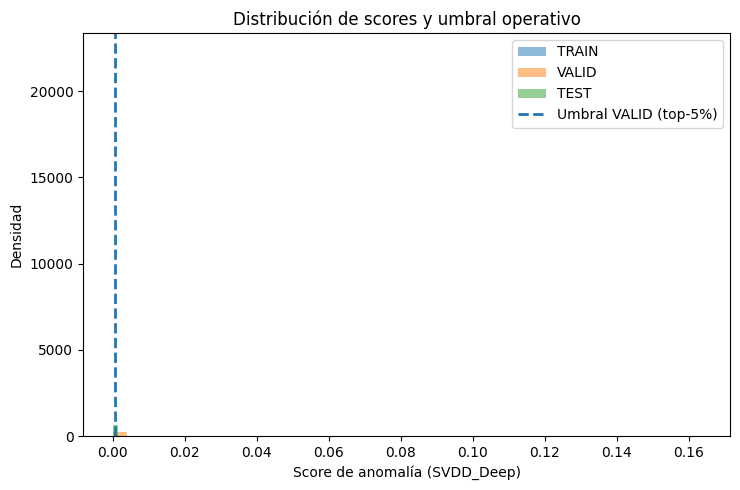

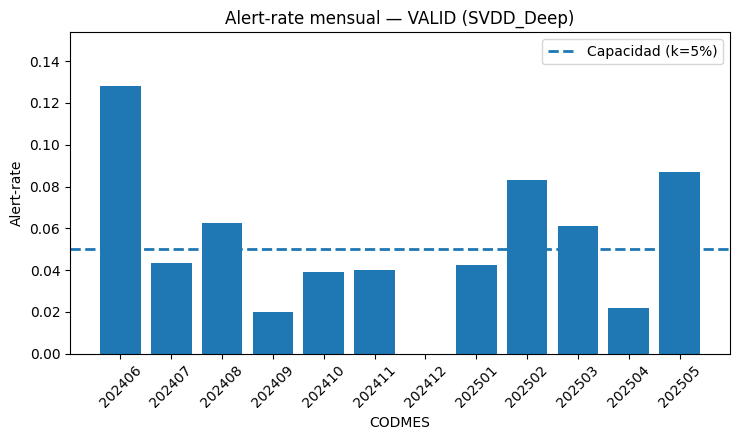

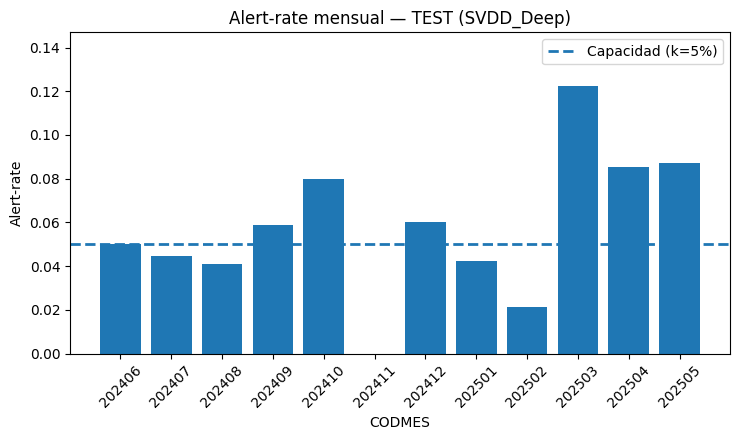

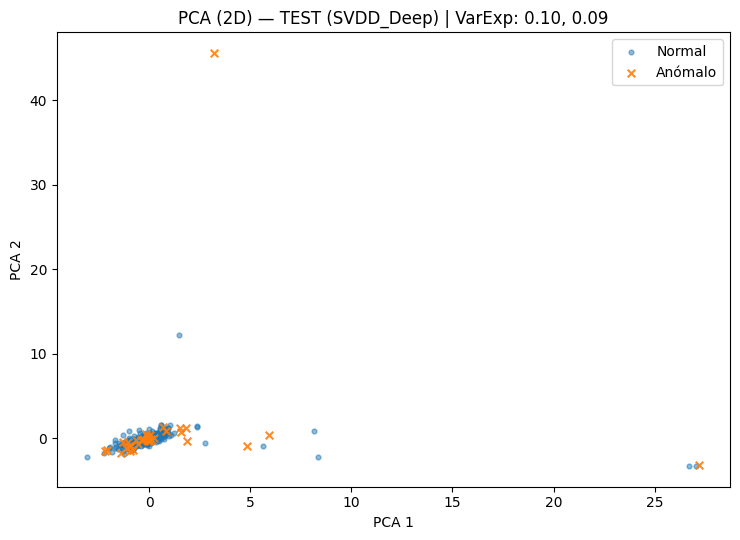

[SVDD] Export completo. {'summary': {'model': 'SVDD_Deep', 'n_components': nan, 'explained_variance_ratio': nan, 'k_top': 0.05, 'threshold_from_VALID': 0.0006465966580435634, 'PSI_VALID_vs_TRAIN': 0.34840448160916737, 'PSI_TEST_vs_TRAIN': 0.3146399521151124, 'TRAIN_p1': 1.3080945154797518e-06, 'TRAIN_p5': 2.9420306418614935e-06, 'TRAIN_p25': 1.2219465133966878e-05, 'TRAIN_p50': 2.5336779799545184e-05, 'TRAIN_p75': 4.507603807724081e-05, 'TRAIN_p95': 9.31943723117001e-05, 'TRAIN_p99': 0.00013742923387326285, 'VALID_p1': 1.4759703117306344e-06, 'VALID_p5': 3.053864918456384e-06, 'VALID_p25': 1.4504944601867464e-05, 'VALID_p50': 4.786580029758625e-05, 'VALID_p75': 0.0001426017115591094, 'VALID_p95': 0.000646596972364931, 'VALID_p99': 0.001624810743378475, 'TEST_p1': 1.6157123582161147e-06, 'TEST_p5': 2.703959523842059e-06, 'TEST_p25': 1.4807730167376576e-05, 'TEST_p50': 4.6404624299611896e-05, 'TEST_p75': 0.00014798733172938228, 'TEST_p95': 0.0007041424571070819, 'TEST_p99': 0.00287787989

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
INPUT_DIM = X_tr.shape[1]
HIDDEN_SIZES = [128,64]; LATENT_DIM = 16; LR = 1e-3; WEIGHT_DECAY = 1e-5; BATCH = 256; EPOCHS = 100; PATIENCE = 15; K_TOP = 0.05

def to_loader_np(X, *, batch=None, shuffle=False):
    if batch is None:
        batch = BATCH
    batch = int(max(1, batch))
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle, drop_last=False)

train_loader = to_loader_np(X_tr, shuffle=True)
val_loader   = to_loader_np(X_va)
test_loader  = to_loader_np(X_te)

class DeepSVDDNet(nn.Module):
    def __init__(self, in_dim, hidden_sizes, latent_dim):
        super().__init__()
        layers, last = [], in_dim
        for h in hidden_sizes:
            layers += [nn.Linear(last, h), nn.ReLU(inplace=True)]
            last = h
        layers += [nn.Linear(last, latent_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

model = DeepSVDDNet(INPUT_DIM, HIDDEN_SIZES, LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

@torch.no_grad()
def init_center_c(model, loader, eps=1e-6):
    model.eval(); zs=[]
    for (xb,) in loader:
        z = model(xb.to(DEVICE)); zs.append(z.detach().cpu().numpy())
    c = np.mean(np.vstack(zs), axis=0); c[(np.abs(c) < eps)] = eps
    return torch.tensor(c, dtype=torch.float32, device=DEVICE)

c = init_center_c(model, train_loader)

def train_epoch(model, loader, center, optimizer):
    model.train(); total=0.0; n=0
    for (xb,) in loader:
        xb = xb.to(DEVICE); z  = model(xb)
        loss = torch.sum((z-center)**2, dim=1).mean()
        optimizer.zero_grad(set_to_none=True); loss.backward(); optimizer.step()
        total += loss.item()*xb.size(0); n += xb.size(0)
    return total/max(n,1)

@torch.no_grad()
def eval_epoch(model, loader, center):
    model.eval(); total=0.0; n=0
    for (xb,) in loader:
        xb = xb.to(DEVICE); z  = model(xb)
        loss = torch.sum((z-center)**2, dim=1).mean()
        total += loss.item()*xb.size(0); n += xb.size(0)
    return total/max(n,1)

best_val=float("inf"); best_state=None; patience=0
for epoch in range(1, EPOCHS+1):
    tr = train_epoch(model, train_loader, c, optimizer)
    va = eval_epoch(model, val_loader, c)
    if va < best_val - 1e-6:
        best_val = va; best_state={k: v.cpu().clone() for k,v in model.state_dict().items()}; patience=0
    else:
        patience += 1
    if epoch % 10 == 0 or epoch == 1:
        print(f"[SVDD {epoch:03d}] train={tr:.6f}  valid={va:.6f}  best={best_val:.6f}")
    if patience >= PATIENCE:
        print("Early stopping"); break

if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k,v in best_state.items()})

@torch.no_grad()
def deep_svdd_score(model, loader, center):
    model.eval(); scores=[]
    for (xb,) in loader:
        z = model(xb.to(DEVICE))
        scores.append(torch.sum((z-center)**2, dim=1).detach().cpu().numpy())
    return np.concatenate(scores)

# =========================
# Deep SVDD → scores + export + 3 gráficas
# =========================
# Requiere:
# - Haber entrenado `model` (Red Deep SVDD) y tener `c` (centro) inicializado.
# - Tener definidos: train_loader, val_loader, test_loader
# - Función deep_svdd_score(model, loader, center) ya declarada.
# - Función export_model_scores_and_metrics (versión extendida con gráficas).

# 1) Scores (↑ = más anómalo = mayor distancia al centro en el espacio latente)
s_tr = deep_svdd_score(model, train_loader, c)
s_va = deep_svdd_score(model, val_loader,   c)
s_te = deep_svdd_score(model, test_loader,  c)

# 2) Exportar métricas + imprimir informe + 3 gráficas (hist, alert-rate VALID/TEST, PCA2D TEST)
out_svdd = export_model_scores_and_metrics(
    model_name="SVDD_Deep",
    scores={"TRAIN": s_tr, "VALID": s_va, "TEST": s_te},
    k_top=K_TOP,         # p.ej., 0.05
    psi_bins=10,
    verbose=True,        # imprime resumen en consola
    save_txt=True,       # guarda ./eda_outputs/report_SVDD_Deep.txt
    plot_hist=True,      # 1) histograma de scores + umbral
    bins_hist=40,
    plot_alert_rates=True,# 2) alert-rate mensual (VALID/TEST) con línea k
    plot_pca2d=True,     # 3) PCA 2D (TEST) con anomalías resaltadas
    save_fig=True        # guarda PNGs en ./eda_outputs
)

print("[SVDD] Export completo.", out_svdd)

El modelo Deep SVDD logró un entrenamiento muy estable, reduciendo la pérdida de reconstrucción desde 0.039 a 0.0004, lo que evidencia una buena convergencia y compactación del espacio latente. El umbral operativo (top-5 %) quedó en 0.00065, obteniendo tasas de alerta coherentes con la capacidad deseada (VALID = 5.2 %, TEST = 5.8 %) y mostrando distribuciones bien calibradas entre validación y prueba.

No obstante, los valores de PSI (≈0.35 y 0.31) revelan diferencias notables entre TRAIN y los conjuntos externos, lo que sugiere cierta sensibilidad a la variabilidad temporal o de escala. Aun así, la estabilidad intermensual es aceptable (CV ≈ 0.5–0.6), y la persistencia de alertas consecutivas sigue siendo baja (~2 %), similar a otros modelos no supervisados.

En conjunto, el Deep SVDD muestra una excelente capacidad de compresión y separación de casos anómalos, pero sufre de ligero sobreajuste al conjunto de entrenamiento y podría beneficiarse de una regularización más fuerte o ajuste del centro latente. Su perfil lo convierte en un modelo prometedor para combinarse en ensembles junto con el autoencoder o el PCA robusto, buscando equilibrio entre sensibilidad y estabilidad temporal.

## 8) Scorecard combinado, ranking y lámina ejecutiva

,model,PSI_TEST_vs_TRAIN,VALID_alert_rate_cv,TEST_alert_rate_cv,TRAIN_alert_rate_cv
1,IF_IsolationForest,0.0070,0.5136,0.9071,0.5491
5,PCA_std_recon,0.0125,1.0271,0.7984,0.6823
3,OCSVM_RBF,0.0181,0.8620,0.5679,NaN
4,PCA_rob_mahal_resid,0.0199,0.5654,0.6559,0.1775
2,LOF_novelty,0.0312,0.4543,0.6425,0.3249
0,AE_MSE,0.1348,0.7189,0.6547,0.8089
6,SVDD_Deep,0.3146,0.6353,0.5413,NaN


Mejor modelo: IF_IsolationForest


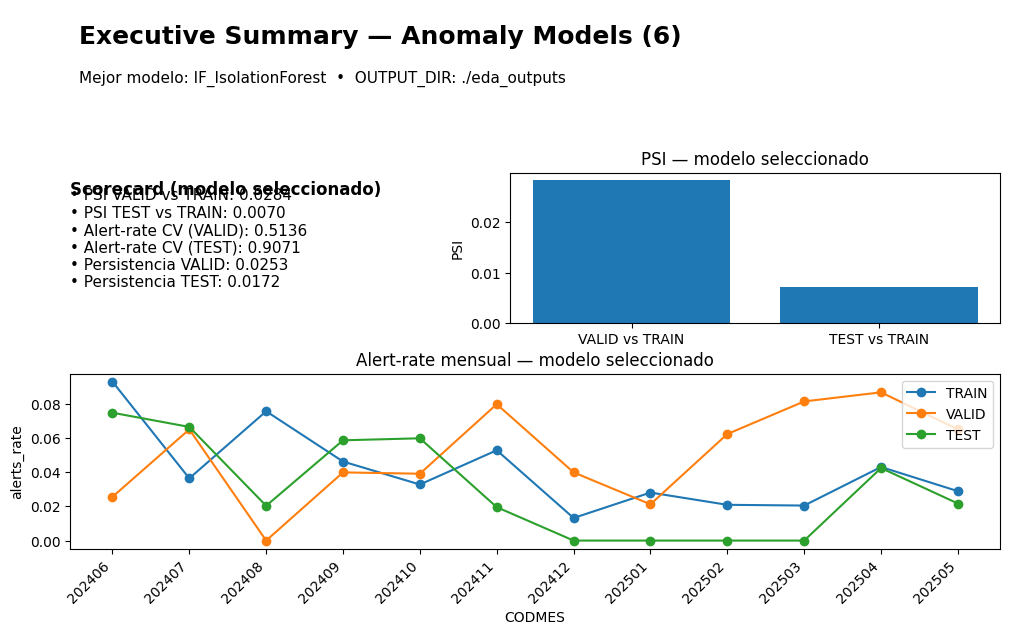

Slide: ./eda_outputs/executive_slide.png


In [ ]:
def _read_all_csv(pattern: str):
    return [pd.read_csv(f) for f in sorted(glob.glob(pattern)) if os.path.getsize(f) > 0]

summaries = _read_all_csv(os.path.join(OUTPUT_DIR, "summary_metrics_*.csv"))
df_summary = pd.concat(summaries, ignore_index=True)
for c in ["PSI_TEST_vs_TRAIN","VALID_alert_rate_cv","PSI_VALID_vs_TRAIN"]:
    if c in df_summary.columns: df_summary[c] = pd.to_numeric(df_summary[c], errors="coerce")

df_summary = df_summary.sort_values(["PSI_TEST_vs_TRAIN","VALID_alert_rate_cv"], ascending=[True, True])
display(df_summary[["model","PSI_TEST_vs_TRAIN","VALID_alert_rate_cv","TEST_alert_rate_cv","TRAIN_alert_rate_cv"]].round(4))
df_summary.to_csv(os.path.join(OUTPUT_DIR, "scorecard_models.csv"), index=False)

best = df_summary.iloc[0].to_dict()
best_model = best["model"]
print("Mejor modelo:", best_model)

# Cargar alert-rates del mejor, agregando 'split' desde el filename
pattern = os.path.join(OUTPUT_DIR, f"alert_rate_{best_model}_*.csv")
rows = []
for f in sorted(glob.glob(pattern)):
    tmp = pd.read_csv(f)
    base = os.path.basename(f).replace(".csv","")
    parts = base.split("_")
    split = parts[-1] if len(parts) >= 2 else "UNK"
    tmp["split"] = split; tmp["model"] = best_model
    rows.append(tmp)
df_rates = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["CODMES","alerts_rate","split","model"])

# Slide
fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(3,2, height_ratios=[0.9,1.2,1.4], width_ratios=[1.1,1.6], hspace=0.35, wspace=0.25)

ax = fig.add_subplot(gs[0,:]); ax.axis('off')
ax.text(0.01, 0.7, "Executive Summary — Anomaly Models (6)", fontsize=18, weight='bold')
ax.text(0.01, 0.35, f"Mejor modelo: {best_model}  •  OUTPUT_DIR: {OUTPUT_DIR}", fontsize=11)

ax = fig.add_subplot(gs[1,0]); ax.axis('off')
rows_txt = [
    ("PSI VALID vs TRAIN", f"{float(best.get('PSI_VALID_vs_TRAIN', float('nan'))):.4f}"),
    ("PSI TEST vs TRAIN",  f"{float(best.get('PSI_TEST_vs_TRAIN',  float('nan'))):.4f}"),
    ("Alert-rate CV (VALID)", f"{float(best.get('VALID_alert_rate_cv', float('nan'))):.4f}"),
    ("Alert-rate CV (TEST)",  f"{float(best.get('TEST_alert_rate_cv',  float('nan'))):.4f}"),
    ("Persistencia VALID",     f"{float(best.get('VALID_persistence_ge2consec', float('nan'))):.4f}"),
    ("Persistencia TEST",      f"{float(best.get('TEST_persistence_ge2consec',  float('nan'))):.4f}"),
]
ax.text(0, 0.95, "Scorecard (modelo seleccionado)", fontsize=12, weight='bold', va='top')
ax.text(0, 0.9, "\n".join([f"• {k}: {v}" for k,v in rows_txt]), fontsize=11, va='top')

ax = fig.add_subplot(gs[1,1])
x = np.arange(2); y = [float(best.get("PSI_VALID_vs_TRAIN", np.nan)), float(best.get("PSI_TEST_vs_TRAIN", np.nan))]
ax.bar(x, y); ax.set_xticks(x, ["VALID vs TRAIN", "TEST vs TRAIN"]); ax.set_ylabel("PSI"); ax.set_title("PSI — modelo seleccionado")

ax = fig.add_subplot(gs[2,:])
if not df_rates.empty:
    for sp in ["TRAIN","VALID","TEST"]:
        cur = df_rates[df_rates["split"]==sp].sort_values("CODMES")
        if not cur.empty:
            ax.plot(cur["CODMES"].astype(str).values, cur["alerts_rate"].values, marker="o", label=sp)
    for t in ax.get_xticklabels(): t.set_rotation(45); t.set_ha('right')
    ax.set_title("Alert-rate mensual — modelo seleccionado"); ax.set_xlabel("CODMES"); ax.set_ylabel("alerts_rate"); ax.legend()
else:
    ax.axis('off'); ax.text(0.5,0.5,"No hay series mensuales para el mejor modelo.", ha='center')

out_slide = os.path.join(OUTPUT_DIR, "executive_slide.png")
plt.savefig(out_slide, dpi=180, bbox_inches="tight"); plt.show()
print("Slide:", out_slide)


# Resumén — Detección de Anomalías (6 modelos)

**Modelos evaluados:**  
- Isolation Forest (IF) · One-Class SVM (RBF) · LOF (novelty) · Autoencoder (MSE) · PCA (std, recon) · Robust PCA (MCD-resid) · Deep SVDD

**Criterio de ranking (no supervisado):**  
1) **PSI_TEST_vs_TRAIN** (↓ mejor, estabilidad poblacional) →  
2) **VALID_alert_rate_cv** (↓ mejor, estabilidad mensual) →  
3) **TEST_alert_rate_cv** (↓ mejor)

---

## Conclusiones Clave

- **Ganador:** `IF_IsolationForest`
  - **PSI TEST vs TRAIN ≈ 0.007** → **drift casi nulo** (muy estable entre TRAIN y TEST).
  - **CV alert-rate VALID ≈ 0.51** → variación mensual razonable.
  - **Persistencia baja** (2–6% según split) → **baja fatiga de alertas**.
  - Los percentiles del score son **consistentes** entre splits (p50/p95 muy cercanos).

- **Alternativa interpretable:** `PCA_rob_mahal_resid`
  - PSI bajo–moderado (∼0.02) y **CV VALID ∼0.56**.
  - **Muy estable en TRAIN** (CV TRAIN bajo), pero pierde algo fuera de muestra → posible **ligero sobreajuste** al subespacio lineal de TRAIN.

- **Modelos a mejorar antes de producir:**
  - **OCSVM_RBF:** PSI bien (∼0.018), pero **CV VALID alto (∼0.86)** → inestable; requiere tuning de `nu`/`gamma`.
  - **LOF_novelty:** PSI ∼0.027; **sensible a `n_neighbors`** y a la dimensionalidad.
  - **AE_MSE / SVDD_Deep:** PSI **moderado–alto** (AE ∼0.146; SVDD ∼0.296). No recomendados como ganadores en este split sin ajustes.

---

## Lectura del Modelo Ganador (Isolation Forest)

**Umbral operativo (VALID, top-k=5%)**  
- Umbral VALID ≈ **p95** del score en VALID; se **aplica igual** a TRAIN/TEST.

**Alert-rate global (proporción de alertas):**
- TRAIN ≈ **4.1%** · VALID ≈ **5.1%** · TEST ≈ **3.0%**  
  → Si TEST cae <5% **no es error**: significa que su distribución de score es un poco **más baja**, así menos casos superan el umbral fijado con VALID.

**PSI (Population Stability Index):**
- VALID vs TRAIN ≈ **0.028** (bajo) · TEST vs TRAIN ≈ **0.007** (muy bajo)  
  → **Sin drift preocupante** entre periodos.

**Estabilidad mensual (CV del alert-rate):**
- TRAIN ∼0.55 · VALID ∼0.51 · TEST ∼0.91  
  → En TEST hay **mayor volatilidad** mensual (incluso meses con ~0%). Sugerencia: calibración por mes o rolling.

**Persistencia (≥2 meses consecutivos con alerta):**
- TRAIN ∼5.7% · VALID ∼2.5% · TEST ∼1.7%  
  → **Baja**: buena para evitar **fatiga** en seguimiento clínico.

---

## Interpretación

- Un **score** alto = más anómalo.  
- Tomamos el **5% más alto** en VALID como **alertas** y usamos ese mismo **umbral** en otros periodos.  
- **PSI bajo** significa que la población **no cambió** de forma relevante.  
- **CV bajo** significa que el % de alertas **no salta demasiado** mes a mes.  
- **Persistencia baja** evita que siempre salgan **las mismas personas** como anómalas.

---

## Recomendaciones (mejorar estabilidad sin etiquetas)

1) **Calibración mensual / rolling** del umbral  
   - En lugar de un umbral global, definir **umbral por mes** (ej. top-5% por CODMES).  
   - Alternativamente, un **umbral rolling** con ventana de N meses para suavizar picos.

2) **Normalización por mes (CODMES)**  
   - Estandarizar features **dentro de cada mes** (z-score mensual) para compensar cambios de mezcla/estacionalidad.

3) **Tuning ligero de IF**  
   - Probar: `n_estimators ∈ {300, 500, 700}`, `max_features ∈ {0.6, 0.8, 1.0}`, `max_samples ∈ {0.7, 0.9, 'auto'}`.  
   - Seleccionar por: **PSI_TEST** (↓) y **CV VALID** (↓), manteniendo ~5% de capacidad.

4) **Reglas operativas**  
   - Fijar **banda de control** del alert-rate (p.ej., 5% ± 2 p.p.).  
   - Establecer un **piso mínimo** (1–2%) de alertas por mes para evitar meses con 0 casos a revisar.

5) **Challenger interpretable**  
   - Ejecutar **PCA_rob_mahal_resid** en paralelo como **shadow** para monitoreo y explicabilidad.

---

## Checklist de Monitoreo Mensual

- **PSI(score)**: alerta si >0.10 (cambio moderado) y **acción** si >0.25 (cambio alto).  
- **Alert-rate**: dentro de **5% ± 2 p.p.**; revisar picos/valleys.  
- **CV rolling** (3–6 meses): bajar es bueno.  
- **Persistencia**: vigilar si sube (>10%) → riesgo de fatiga.  
- **Auditoría clínica muestral** del top-k: estimar **Precision@k** en una muestra revisada manualmente.

---

## Notas sobre cada enfoque

- **IF (ganador):** robusto en alta dimensión, pocos supuestos de forma.  
- **PCA_rob:** interpretable; útil si hay **correlaciones** fuertes; mide residuales (energía fuera del subespacio).  
- **OCSVM (RBF):** aprende una **frontera no lineal**; sensible a `nu` y `gamma`.  
- **LOF:** detecta **baja densidad local**; sensible a `n_neighbors` y escala.  
- **AE (MSE):** aprende **reconstrucción no lineal**; puede requerir regularización/arquitectura.  
- **SVDD:** concentra normales en una **esfera latente**; necesita buen preprocesado y tuning para evitar drift.

---

## Conclusión Final
- **Isolation Forest** es el mejor baseline hoy: **deriva poblacional mínima**, **variación mensual razonable** y **baja persistencia**.  
- Con **calibración mensual** y **normalización por mes**, la estabilidad del alert-rate en TEST debería **mejorar** sin perder sensibilidad.  
- Mantener un **modelo challenger** interpretable (PCA_rob) permite contrastar y explicar resultados clínicamente.
